Nike Price Prediction

**Members**: Melahat Tayli, Arjun Singh, Artemio Mendoza-Garcia, Paulo Silva, Wa’il Choudar


<hr style="height:2pt">



## Main Notebook: Data Scraping, EDA, Vectorizing, Feature Reduction, and Model Stacking


<a id="contents"></a>

### Notebook contents

- [**STEP 0: Data acquisition**](#part0) download data from Nike.com using homade class NikeScrAPI

- [**STEP 1: EDA and Feature Engineering**](#part1) download data from Nike.com using NikeScrAPI

- [**STEP 2: Text processing and Vectorization**](#part2) expand features to sparse matrix

- [**STEP 3: Feature Selection**](#part3) we use Lasso with Crossvalidation to get feature importance

- [**STEP 4: Hyperparameter tuning**](#part4) for depth*, number of estimators and feature reduction

- [**STEP 5: All together: Stacking**](#part5) testing performance when stacking models

- [**STEP 6: Simple Boosting**](#part6) comparing Random Forest and Gradient Boosting Regressor 


In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

In [2]:
# You may need to install GENSIM
# !pip install gensim

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor,  AdaBoostClassifier, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RepeatedKFold
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords, preprocess_string
from IPython.display import Latex

from bs4 import BeautifulSoup
from os import path
import os
import json

from datetime import datetime
from tqdm import tqdm
import warnings

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

# msg helper
def print_msg(text, char='-',side='*', marquee=True ):
    '''
    simple helper to print out a text
    '''
    formatted_text = side+'  '+text+'  '+side
    mylen = len(formatted_text)
    marquesina = ''.join([char for i in range(mylen)])
    if marquee:
        print(marquesina)
        print(formatted_text)
        print(marquesina)
    else:
        print(f'{side}{text}')

<a id="part0"></a>
## STEP 0: Scrape products from NIKE.com by piggybacking on nike's webdev API

#### Scrape class
To get the products from nike.com, we are using the webapp's API that the search engine is consuming. We wrapped it as a class to make it flexible and reusable.

This class will download ALL products listed in nike.com website, not only shoes. 
The shoes are selected with productType= 'FOOTWEAR'

This class is highly configurable, look the options to set it up correctly<br/>

The results are stored in a predefined file<br/>

Intermediate results for each shoe category are stored in temporary files, in case there is a crahs, the process can restart with only the missing classes. Or, we can fetch a single class if needed.


In [4]:
class NikeScrAPI:   
    '''
    Uses nike's website API to scrape data.
        NOTE: for production set max_pages = 200
    '''
    def __init__(self, country='US', 
                 lan='en', max_pages=1, 
                 get_description=True, 
                 single_category=None, 
                 debug=False, 
                 filename='nike',
                 path='data',
                 write = True
                ):
        
        self.__count = 24
        self.__page_size = 24
        self.__country = country
        self.__lan = lan
        self.__DEBUG = debug
        self.__url_base = "https://www.nike.com" 
        self.__DEFAULT_REQUESTS_TIMEOUT = (5, 15) # for example
        self.__filePrefix = filename
        self.__path = path
        self.__write_to_disk = write
        
        # If TRUE, then it gets the full description and ratings from each product's url. 
        # Takes more time, but data is complet
        self.__full_description = get_description
        
        # Estimated max number of pages in each category
        self.__max_number_of_pages = max_pages  # recommended 200 for production, 1 for testing
        
        # Data Structure
        self.shoeDict = { 
            'UID':[],
            'cloudProdID':[],
            'productID':[],
            'shortID':[],
            'colorNum':[],
            'title':[],
            'subtitle':[],
            'category':[],
            'type':[],
            'currency':[],
            'fullPrice':[],
            'currentPrice':[],
            'sale':[],
            'TopColor':[],
            'channel':[],
            'short_description':[],
            'rating':[],
            
            'customizable': [],
            'ExtendedSizing': [],           
            'inStock': [],
            'ComingSoon': [],
            'BestSeller': [],
            'Excluded': [],
            'GiftCard': [],
            'Jersey': [],
            'Launch': [],
            'MemberExclusive': [],
            'NBA': [],
            'NFL': [],
            'Sustainable': [],
            'label': [],
            'prebuildId': [],
            'prod_url':[],

            'color-ID':[],
            'color-Description':[],
            'color-FullPrice':[],
            'color-CurrentPrice':[],
            'color-Discount':[],
            'color-BestSeller':[],
            'color-InStock':[],
            'color-MemberExclusive':[],
            'color-New':[],
            'color-Label':[],
            'color-Image-url':[],
        } 
        
        # Nike shoe categories
        if single_category:
            self.categories=[single_category] 
        else:
            self.categories=[
                'cycling',
                'jordan', 
                'running',
                'golf', 
                'training',
                'tennis',
                'football',
                'basketball',
                'boot',
                'baseball',
                'soccer',
                'hiit',
                'volleyball',
                'lifestyle',
            ]
        
    def __repr__(self):
        return f'{type(self).__name__}({self.__max_number_of_pages!r})'   

    def __log_exception(self,e, verb, url, kwargs):
        '''
        log get exceptions (code from https://stackoverflow.com/questions/16511337/correct-way-to-try-except-using-python-requests-module)
        '''
        print(f'exception - Error {e}, {verb}')
        # raw_tb = traceback.extract_stack()
        # if 'data' in kwargs and len(kwargs['data']) > 500: # anticipate giant data string
        #     kwargs['data'] = f'{kwargs["data"][:500]}...'  
        # msg = f'BaseException raised: {e.__class__.__module__}.{e.__class__.__qualname__}: {e}\n' \
        #     + f'verb {verb}, url {url}, kwargs {kwargs}\n\n' \
        #     + 'Stack trace:\n' + ''.join(traceback.format_list(raw_tb[:-2]))
        # logger.error(msg) 

    def __requests_call(self,verb, url, **kwargs):
        '''
        request wrapper call (code from https://stackoverflow.com/questions/16511337/correct-way-to-try-except-using-python-requests-module)
        '''
        response = None
        exception = None
        try:
            if 'timeout' not in kwargs:
                kwargs['timeout'] = self.__DEFAULT_REQUESTS_TIMEOUT
            response = requests.request(verb, url, **kwargs)
        except BaseException as e:
            self.__log_exception(e, verb, url, kwargs)
            exception = e
        return (response, exception)

    def __getRating(self,indiv_shoe_soup):
        '''
        try to get the ratings for a given product
        '''
        try:
            return indiv_shoe_soup.find('p', class_='d-sm-ib pl4-sm').text.split()[0]
        except AttributeError:
            return np.NaN


    def __getDescription(self,indiv_shoe_soup): 
        '''
        tries to get the short description of a given product
        '''
        div_desc = indiv_shoe_soup.find('div', attrs={'class':'description-preview'})
        try:
            description = div_desc.find('p').text
        except AttributeError:
            return np.NaN

        return description
            
    def getDescAndRatings(self, url):
        '''
        gets description and ratings at once, from product url
        '''
        # Gets website page from prod_url
        indiv_shoe_page, exception  = self.__requests_call('get',url)
                
        if not exception :
           indiv_shoe_soup = BeautifulSoup(indiv_shoe_page.text,'html.parser')
           short_desc = self.__getDescription(indiv_shoe_soup)
           rating     = self.__getRating(indiv_shoe_soup) 
        else:
           rating = np.NaN
           short_desc = np.NaN  
                
        return short_desc, rating
    
    def updateDescriptionAndRatings(self, df, category):
        '''
        iterates over a dataframe to get description and rating for each shoe,from product URL
        '''        
        old_product_id  = None

        for index in tqdm(df[df['category']==category].index, desc=category.upper()):   

            shoe = df.loc[index]
            new_product_id = shoe['productID']

            if new_product_id != old_product_id:
                if self.__DEBUG: print(f">>>New Product {new_product_id}")

                # Gets website page from prod_url
                url = shoe['prod_url']
                
                shor_desc, rating = self.getDescAndRatings(url) 

                if self.__DEBUG: print(f"({shoe['title']}), {short_desc}")
                if self.__DEBUG: print(url)

                old_product_id = new_product_id

            else:
                if self.__DEBUG: print('same product')

            df.at[index,'short_description'] = short_desc
            df.at[index,'rating'] = rating

    def __getProducts(self, category,  anchor=0):
        '''
        retrieve products from website
        '''    
        country = self.__country
        country_language = self.__lan 
        count=self.__page_size

        query = category
        
        # Nike website's API
        url = f'https://api.nike.com/cic/browse/v2?queryid=products&anonymousId=241B0FAA1AC3D3CB734EA4B24C8C910D&country={country}&endpoint=%2Fproduct_feed%2Frollup_threads%2Fv2%3Ffilter%3Dmarketplace({country})%26filter%3Dlanguage({country_language})%26filter%3DemployeePrice(true)%26searchTerms%3D{query}%26anchor%3D{anchor}%26consumerChannelId%3Dd9a5bc42-4b9c-4976-858a-f159cf99c647%26count%3D{count}&language={country_language}&localizedRangeStr=%7BlowestPrice%7D%E2%80%94%7BhighestPrice%7D'

        # Calls API 
        html, exception = self.__requests_call('get',url)
        
        output = json.loads(html.text)

        if self.__DEBUG : print(f'category:{query} anchor:{anchor} count:{count}')

        return output['data']['products']['products']

    def __setFilePrefix(self):
        '''
        set the timestamp to file prefix
        '''
        # get timestamp
        today = (datetime.now()).strftime('%d%b%Y_%H%M')
        timestamp = today.upper()
        
        self.__filePrefix = f'{self.__filePrefix}_{timestamp}'
        
    def __checkPath(self,path):
        '''
        verifies if path exits
        '''
        if not os.path.exists(path):
            os.makedirs(path)
            
    def __writeIntermediateFile(self, category):
        '''
        writes down an intermediate file with last category
        '''  
        if self.__write_to_disk:
        
            # get number of current file (out of N categories)
            current = self.categories.index(category) + 1
            label = f'{category}_{current}_of_{len(self.categories)}'

            file_name = f'{self.__filePrefix}_{label}.csv'

            file_full_path = os.path.join(self.__path,'tmp',file_name) 

            # converts data dictionary to dataframe and removes duplicates
            shoes = pd.DataFrame(self.shoeDict)
            shoes = shoes.drop_duplicates(subset='UID')

            # get rows only for current category
            shoes = shoes[shoes['category']==category]

            shoes.to_csv(file_full_path)

            print(f"Intermediate file for category [{category}] saved as '{file_full_path}'")
            if self.__DEBUG: print(f'Saved itermediate file {file_full_path}')
    
    def __writeFinalFile(self, shoes):
        '''
        writes final file name
        '''
        if self.__write_to_disk:
            file_name = f'{self.__filePrefix}.csv'

            file_full_path = os.path.join(self.__path, file_name)

            # Saves dataframe as CSV
            shoes.to_csv(file_full_path)        

    def __writeDictionary(self,category, k, item, color, short_desc, rating, prod_url):
        '''
        add rows to the Data Frame Dictionary
        '''
        # add surrogate IDs for shoe and color    
        self.shoeDict['colorNum'].append(k+1)
        self.shoeDict['UID'].append(item['cloudProductId']+color['cloudProductId'])
        self.shoeDict['productID'].append(item['id'])
        self.shoeDict['cloudProdID'].append(item['cloudProductId'])
        self.shoeDict['shortID'].append(item['id'][-12:]) 
        
        self.shoeDict['type'].append(item['productType'])
        self.shoeDict['category'].append(category)
        self.shoeDict['title'].append(item['title'])
        self.shoeDict['subtitle'].append(item['subtitle'])
        self.shoeDict['short_description'].append(short_desc)
        self.shoeDict['rating'].append(rating)                                                                                 
        
        self.shoeDict['currency'].append(item['price']['currency'])
        self.shoeDict['fullPrice'].append(item['price']['fullPrice'])
        self.shoeDict['sale'].append(item['price']['discounted'])
        self.shoeDict['currentPrice'].append(item['price']['currentPrice'])
        self.shoeDict['TopColor'].append(item['colorDescription'])
        self.shoeDict['channel'].append(item['salesChannel'])
        self.shoeDict['prod_url'].append(prod_url)

        self.shoeDict['customizable'].append(item['customizable'])
        self.shoeDict['ExtendedSizing'].append(item['hasExtendedSizing'])          
        self.shoeDict['inStock'].append(item['inStock'])
        self.shoeDict['ComingSoon'].append(item['isComingSoon'])
        self.shoeDict['BestSeller'].append(item['isBestSeller'])
        self.shoeDict['Excluded'].append(item['isExcluded'])
        self.shoeDict['GiftCard'].append(item['isGiftCard'])
        self.shoeDict['Jersey'].append(item['isJersey'])
        self.shoeDict['Launch'].append(item['isLaunch'])
        self.shoeDict['MemberExclusive'].append(item['isMemberExclusive'])
        self.shoeDict['NBA'].append(item['isNBA'])
        self.shoeDict['NFL'].append(item['isNFL'])
        self.shoeDict['Sustainable'].append(item['isSustainable'])
        self.shoeDict['label'].append(item['label'])
        self.shoeDict['prebuildId'].append(item['prebuildId'])

        # Color Components
        self.shoeDict['color-ID'].append(color['cloudProductId'])
        self.shoeDict['color-Description'].append(color['colorDescription'])
        self.shoeDict['color-FullPrice'].append(color['price']['fullPrice'])
        self.shoeDict['color-CurrentPrice'].append(color['price']['currentPrice'])
        self.shoeDict['color-Discount'].append(color['price']['discounted'])
        self.shoeDict['color-BestSeller'].append(color['isBestSeller'])
        self.shoeDict['color-Image-url'].append(color['images']['portraitURL']) 
        self.shoeDict['color-InStock'].append(color['inStock'])

        self.shoeDict['color-MemberExclusive'].append(color['isMemberExclusive'])
        self.shoeDict['color-New'].append(color['isNew'])
        self.shoeDict['color-Label'].append(color['label'])        
        
    def getData(self):
        '''
        Happy Scraping! 
        Main Method to Scrape Data. It cycles across all elements
        '''
        # reset file prefix for this run
        self.__setFilePrefix()
        # check temp and data directories exist
        self.__checkPath(self.__path)
        self.__checkPath(os.path.join(self.__path,'tmp'))
        
        # count stores the number of rows scrapped per page
        count = self.__count
        anchor = 0
        total_rows = 0

        # get info for each category in the website
        for category in (self.categories): 
            # print(f"Processing category '{category.upper()}'")
            page_number = 0

            # load new pages from the search engine
            for page_number in tqdm(range(self.__max_number_of_pages), desc=category.upper()):

                # Get new html page
                anchor = page_number * self.__page_size  
                output = self.__getProducts(category=category, anchor=anchor)
                page_number +=1
                if self.__DEBUG: print(f'category: {category}, rows: {total_rows}, type(output):{type(output)}')

                # If output is empty, breaks the loop, ending the search for this category
                if output == None:
                    if self.__DEBUG: print(f'End processing searched {i} pages, {rows} rows, {tenis_rows} footwear')
                    break
                else:

                    # Loop through products and print name
                    for j, item in enumerate(output):

                        # pick only footwear, filtering out everything else      
                        if item['productType'] == 'FOOTWEAR': 
                            
                            # Retrieve short description and ratings this makes the process 10X slower
                            prod_url = item['url'].replace('{countryLang}',self.__url_base)
                            
                            short_desc = np.NaN
                            rating = np.NaN
                            if self.__full_description:
                                short_desc, rating = self.getDescAndRatings(prod_url)

                            # Retrieves features for each color 
                            for k, color in enumerate(item['colorways']):
                                self.__writeDictionary(category, k, item, color, short_desc, rating, prod_url)
                                total_rows +=1
                                
                                if self.__DEBUG :
                                    print(f"{j}:{k}:{item['cloudProductId'][-12]+color['cloudProductId']}:{item['title']},{item['subtitle']},{color['colorDescription']}")
                          
            # writes intermediate file
            self.__writeIntermediateFile(category)      
        
        # Remove Dupes
        shoes = pd.DataFrame(self.shoeDict)
        shoes = shoes.drop_duplicates(subset='UID')
        
        self.__writeFinalFile(shoes)
        
        # final message
        print(f'\nScraping Finished, Total {total_rows} items processed')
        print(f"total rows in dataframe:{len(shoes['UID'])}, unique rows:{len(shoes['UID'].unique())}")
        
        file_full_path = os.path.join(f'{self.__filePrefix}.csv', self.__path) 
        print(f"final dataset file saved as '{file_full_path}'")
        
        return shoes



### Scraping Nike
#### Saves full Scraped data to file: 
#####       *data/nike_DDMMYYYY_HHMM.csv*</div>

It will instantiate a scrape class to dowload all shoes from nike.com. and write it down to a csv file. 
The entire process takes around 60 to 90 minutes. 

**NOTE for TA**: We are scraping just a fraction of data in realtime, the bulkd is being read from a preloaded file. The reason is not to download the whole database every time this notebook runs, as it takes long time. 

In a real life project the scrape process would be a separated job and run in a pipelined process as input for EDA and Feature Engineering. However, for completness reasons we have everything in one single notebook (as required).

If you want to scrape the whole dataset in real time, set up <i>__PRELOAD = False</i>

* Set max_pages = 300 to get the whole database

* Parameters: ( max_pages=300, path='data')

* You can look intermediate files for each category in the temporary file (path=data/tmp).

In [5]:
initial_time=datetime.now() 
print_msg(f'START at: {initial_time}') 

# Scrape Nike!
# For quick test, set up:
#.  category='cycling' iterate over a single category 
#.  set max_pages = 1 -> only one page from catalog
#.  write = False -> doesn't write to disk
__PRELOAD = True


if __PRELOAD:
    # loading pre-scraped data (fast path)
    max_pages = 3
    write = False
    get_description = False 
    
    # reading BASELINE datafile (known dataset)
    INPUT_FILE  =  'data/nike_06DEC2022_1708.csv'
    df = pd.read_csv(INPUT_FILE)    
else:
    # re-training with fresh scraped data (slow run)
    max_pages = 300
    write = True
    get_description = True
      
# Instantiate NikeScrAPI class
nikeAPI = NikeScrAPI(max_pages=max_pages, 
                     write=write, 
                     get_description=get_description, 
                     path='data')        

# Let's get some data!
nike = nikeAPI.getData()
    

------------------------------------------
*  START at: 2022-12-11 14:54:04.025786  *
------------------------------------------


LIFESTYLE: 100%|██████████████████████████████████| 3/3 [00:01<00:00,  1.95it/s]


Scraping Finished, Total 1416 items processed
total rows in dataframe:1371, unique rows:1371
final dataset file saved as 'nike_11DEC2022_1454.csv/data'


## Looking basic information about the scraped data
This is just to have a basic understanding on what data we got, EDA is coming in next step below.

In [6]:
# Data Description
print_msg(f'Dataframe Shape: Rows:{df.shape[0]} Columns:{df.shape[1]}')
display(df.info())
display(df.head(5))
print_msg('\nTable 0.1 - RAW DATA from Nike.com',side='',marquee=False)    

-------------------------------------------
*  Dataframe Shape: Rows:4844 Columns:45  *
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4844 entries, 0 to 4843
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             4844 non-null   int64  
 1   UID                    4844 non-null   object 
 2   cloudProdID            4844 non-null   object 
 3   productID              4844 non-null   object 
 4   shortID                4844 non-null   object 
 5   colorNum               4844 non-null   int64  
 6   title                  4844 non-null   object 
 7   subtitle               4844 non-null   object 
 8   category               4844 non-null   object 
 9   type                   4844 non-null   object 
 10  currency               4844 non-null   object 
 11  fullPrice              4844 non-null   int64  
 12  currentPrice           4844 

None

,Unnamed: 0,UID,cloudProdID,productID,shortID,colorNum,title,subtitle,category,type,currency,fullPrice,currentPrice,sale,TopColor,channel,short_description,rating,customizable,ExtendedSizing,inStock,ComingSoon,BestSeller,Excluded,GiftCard,Jersey,Launch,MemberExclusive,NBA,NFL,Sustainable,label,prebuildId,prod_url,color-ID,color-Description,color-FullPrice,color-CurrentPrice,color-Discount,color-BestSeller,color-InStock,color-MemberExclusive,color-New,color-Label,color-Image-url
0,0,43070a72-0b17-56cf-8335-aef1ff9dd04843070a72-0...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,1,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,43070a72-0b17-56cf-8335-aef1ff9dd048,Black/Anthracite/Habanero Red/Phantom,120.0,58.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
1,1,43070a72-0b17-56cf-8335-aef1ff9dd048b4acd5f7-f...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,2,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,b4acd5f7-f71e-51ae-92d4-12af42c6d63f,Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...,120.0,84.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
2,2,43070a72-0b17-56cf-8335-aef1ff9dd0483426a9a3-a...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,3,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,3426a9a3-ab9f-5ecd-97ca-f7da1f90b623,White/Black,120.0,84.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
3,3,43070a72-0b17-56cf-8335-aef1ff9dd048777d62b6-d...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,4,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,777d62b6-d083-58d1-9d68-a49cebbbee57,Black/Hyper Crimson/Metallic Silver,120.0,58.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
4,4,43070a72-0b17-56cf-8335-aef1ff9dd048ac42be38-8...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,5,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,ac42be38-8dce-5d9c-94ec-ff54058cf3e4,White/Black/Chutney/Volt,120.0,72.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."



Table 0.1 - RAW DATA from Nike.com


#### Let's see if there are any shoes without description?

In [7]:
# How many rows without description?
df[df['short_description'] == 'NaN']

,Unnamed: 0,UID,cloudProdID,productID,shortID,colorNum,title,subtitle,category,type,currency,fullPrice,currentPrice,sale,TopColor,channel,short_description,rating,customizable,ExtendedSizing,inStock,ComingSoon,BestSeller,Excluded,GiftCard,Jersey,Launch,MemberExclusive,NBA,NFL,Sustainable,label,prebuildId,prod_url,color-ID,color-Description,color-FullPrice,color-CurrentPrice,color-Discount,color-BestSeller,color-InStock,color-MemberExclusive,color-New,color-Label,color-Image-url


#### How do the shoe descriptions look?
Description is an important feature for our project, let's see what we have 
for a few shoes

In [8]:
# Specific product
df[['title','subtitle','short_description']].loc[3971:3973]

,title,subtitle,short_description
3971,Nike Air Max Correlate,Women's Shoes,The Nike Air Max Correlate sets you up in thro...
3972,Nike Air Force 1 GTX,Men's Shoes,The radiance lives on in the Nike Air Force 1 ...
3973,Nike Aqua Sock 360,Baby/Toddler Shoes,Let them keep splashing in this made-for-water...


<a id="part1"></a>
## STEP 1: EDA and Feature Engineering

Once we get the Raw data from the previous step, we preform a Exploratory Data Analysis, cleansing and Feature Engineering to prepare our data for Tokenization and Vectorization.

Sub tasks for this step:<br/> 

    1) EDA and data cleansing 
    2) Feature Engineering
    
---

### SubTask 1: Exploratory Data Analysis and Data Cleansing

We downloaded 4,844 rows of data with 45 fields.

We found that there are 110/4,844 shoes with a missing short description (NaN).

The "prebuildId" field is almost empty, with only 94 rows containing data.

Overall, the quality of the data is good, with almost no missing information (97.7% completeness).

There are 5 text columns that describe the shoes:

* title
* short_description
* subtitle
* category
* color-Description

We are interested in predicting the following values:

* Full Price (numerical, price without discount)
* Current Price (numerical, discounted price)
* Sale (boolean indicator, whether the shoe is on sale or not)

Therefore, our models will be two regression models and one classification model.

In [9]:
# Save reduced features to file
_SAVE_TO_DISK = False
  
# Quick info
print_msg(f'Dataframe Shape: Rows:{df.shape[0]} Columns:{df.shape[1]}')
display(df.info())
display(df.describe())
display(df.head(5))
display(df.iloc[:,2:].nunique())
print_msg('\nTable 1.0 - Initial DataFrame from Scrape process.',side='',marquee=False)    

-------------------------------------------
*  Dataframe Shape: Rows:4844 Columns:45  *
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4844 entries, 0 to 4843
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             4844 non-null   int64  
 1   UID                    4844 non-null   object 
 2   cloudProdID            4844 non-null   object 
 3   productID              4844 non-null   object 
 4   shortID                4844 non-null   object 
 5   colorNum               4844 non-null   int64  
 6   title                  4844 non-null   object 
 7   subtitle               4844 non-null   object 
 8   category               4844 non-null   object 
 9   type                   4844 non-null   object 
 10  currency               4844 non-null   object 
 11  fullPrice              4844 non-null   int64  
 12  currentPrice           4844 

None

,Unnamed: 0,colorNum,fullPrice,currentPrice,rating,prebuildId,color-FullPrice,color-CurrentPrice
count,4844.000000,4844.000000,4844.000000,4844.000000,4678.000000,9.400000e+01,4844.000000,4844.000000
mean,2630.803262,3.491742,107.501445,96.260006,3.572574,6.559510e+09,107.443016,95.625136
std,1592.067186,3.301264,48.587458,47.233992,1.932851,2.488307e+09,48.463076,46.811924
min,0.000000,1.000000,25.000000,13.970000,0.000000,1.830307e+09,24.000000,13.970000
25%,1248.750000,1.000000,70.000000,60.000000,3.700000,5.013001e+09,70.000000,60.000000
50%,2569.500000,2.000000,100.000000,87.970000,4.600000,6.668557e+09,100.000000,85.970000
75%,3974.500000,5.000000,140.000000,127.970000,4.800000,8.872017e+09,140.000000,125.000000
max,5573.000000,32.000000,350.000000,305.000000,5.000000,9.991851e+09,350.000000,305.000000


,Unnamed: 0,UID,cloudProdID,productID,shortID,colorNum,title,subtitle,category,type,currency,fullPrice,currentPrice,sale,TopColor,channel,short_description,rating,customizable,ExtendedSizing,inStock,ComingSoon,BestSeller,Excluded,GiftCard,Jersey,Launch,MemberExclusive,NBA,NFL,Sustainable,label,prebuildId,prod_url,color-ID,color-Description,color-FullPrice,color-CurrentPrice,color-Discount,color-BestSeller,color-InStock,color-MemberExclusive,color-New,color-Label,color-Image-url
0,0,43070a72-0b17-56cf-8335-aef1ff9dd04843070a72-0...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,1,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,43070a72-0b17-56cf-8335-aef1ff9dd048,Black/Anthracite/Habanero Red/Phantom,120.0,58.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
1,1,43070a72-0b17-56cf-8335-aef1ff9dd048b4acd5f7-f...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,2,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,b4acd5f7-f71e-51ae-92d4-12af42c6d63f,Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...,120.0,84.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
2,2,43070a72-0b17-56cf-8335-aef1ff9dd0483426a9a3-a...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,3,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,3426a9a3-ab9f-5ecd-97ca-f7da1f90b623,White/Black,120.0,84.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
3,3,43070a72-0b17-56cf-8335-aef1ff9dd048777d62b6-d...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,4,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,777d62b6-d083-58d1-9d68-a49cebbbee57,Black/Hyper Crimson/Metallic Silver,120.0,58.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."
4,4,43070a72-0b17-56cf-8335-aef1ff9dd048ac42be38-8...,43070a72-0b17-56cf-8335-aef1ff9dd048,e3f1f4d0-b408-4b2f-8135-b49874fa3cbe,b49874fa3cbe,5,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,FOOTWEAR,USD,120,58.97,True,Black/Anthracite/Habanero Red/Phantom,"['NikeApp', 'Nike.com', 'Nike Store Experiences']",The Nike SuperRep Cycle brings a breathable de...,4.3,False,False,True,False,False,False,False,False,False,False,False,False,False,IN_STOCK,NaN,https://www.nike.com/t/superrep-cycle-womens-i...,ac42be38-8dce-5d9c-94ec-ff54058cf3e4,White/Black/Chutney/Volt,120.0,72.97,True,False,True,False,False,IN_STOCK,"https://static.nike.com/a/images/c_limit,w_400..."


cloudProdID              1639
productID                1640
shortID                  1640
colorNum                   32
title                     918
subtitle                  209
category                   14
type                        1
currency                    1
fullPrice                  74
currentPrice              189
sale                        2
TopColor                 1168
channel                     4
short_description        1374
rating                     28
customizable                2
ExtendedSizing              1
inStock                     2
ComingSoon                  2
BestSeller                  2
Excluded                    1
GiftCard                    1
Jersey                      1
Launch                      2
MemberExclusive             2
NBA                         1
NFL                         1
Sustainable                 2
label                       9
prebuildId                 55
prod_url                 1640
color-ID                 4580
color-Desc


Table 1.0 - Initial DataFrame from Scrape process.


### Removes the first rows and drops columns with too many NaNs

First row has no info, so, we don't need it. Also, we remove the rows without description

In [10]:
# Removes the first rows and drops column "prebuild" as it has too many NaNs
df = df.iloc[:,4:]
df.drop('prebuildId', axis=1, inplace=True)

In [11]:
# How many missing descriptions and ratings?
missing_desc = len(df[df['short_description'].isna()]['shortID'])
missing_ratings =  len(df[df['rating'].isna()]['shortID'])
total_rows = len(df)

my_msg = (f'total rows:{total_rows}: missing descriptions {missing_desc} {round(missing_desc/total_rows*100,2)}%, missing ratings {missing_ratings} {round(missing_ratings/total_rows*100,2)}%')
print_msg(my_msg)

-------------------------------------------------------------------------------
*  total rows:4844: missing descriptions 64 1.32%, missing ratings 166 3.43%  *
-------------------------------------------------------------------------------


In [12]:
# This are too few rows, we can drop them
df = df.dropna()
my_msg=f'Number of NaN rows left: {len(df)}'
print_msg(my_msg)

-----------------------------------
*  Number of NaN rows left: 4677  *
-----------------------------------


### We encode the "subtitle" into "Subcategory", grouping similar features in sub-category classes


In [13]:
# Add a subcategory

df['subcategory'] = 'unknown'

subcategories = [{'Women':'woman'},{'^Men':'man'},{'Kids':'kid'},
                 {'Big Kid':'big_kid'},{'Boy':'boy'},
                {'Little Kid':'little_kids'},{'Baby/Toddler':'baby_toddler'},
                {'Infant/Toddler':'infant_toddler'},{'Unisex':'unisex'},
                {'Toddler':'toddler'},{'Baby':'baby'},{'Crib':'baby'}]

print_msg('Encoded Subcategories')

for item in subcategories:
    
    subcategory = list(item.values())[0]
    name = list(item.keys())[0]
    
    count = 0
    
    for index in df.loc[df['subtitle'].str.contains(name,case=False)].index:
        df.loc[index,'subcategory'] = subcategory
        count += 1
        
    print(f'{count} rows from {name} set as {subcategory}')
    
print_msg('\nTable 1.1 - new subcategories field encoded from the field "subcategory".',side='',marquee=False)    

---------------------------
*  Encoded Subcategories  *
---------------------------
987 rows from Women set as woman
1527 rows from ^Men set as man
967 rows from Kids set as kid
604 rows from Big Kid set as big_kid
2 rows from Boy set as boy
363 rows from Little Kid set as little_kids
358 rows from Baby/Toddler set as baby_toddler
21 rows from Infant/Toddler set as infant_toddler
7 rows from Unisex set as unisex
382 rows from Toddler set as toddler
372 rows from Baby set as baby
12 rows from Crib set as baby

Table 1.1 - new subcategories field encoded from the field "subcategory".


## Price distribution per category and subcategory.

From Figure 1.1, we can see the distribution of prices across different categories and subcategories. We observe that the biggest customers are men, followed by women. The category with the least expensive shoes is "volleyball." By examining this distribution, we can gain insights into the preferences and spending habits of different customer groups, which can inform our marketing and pricing strategies.

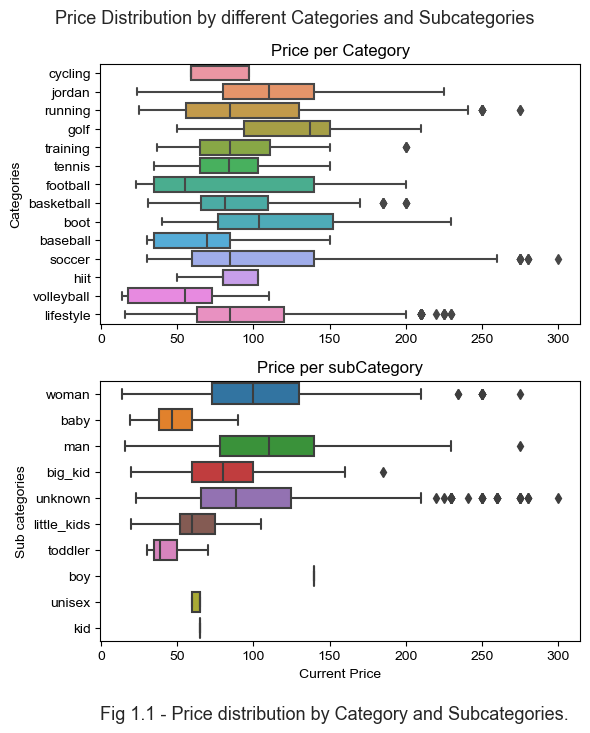

In [14]:
fig, ax = plt.subplots(2,1, figsize=(6,7))
ax=ax.ravel()
sns.set_style('whitegrid')

sns.boxplot(data=df, x='currentPrice', y='category',ax=ax[0])
ax[0].set_title('Price per Category', fontsize=12)
ax[0].set_xlabel(None)
ax[0].set_ylabel('Categories', fontsize=10)

sns.boxplot(data=df, x='currentPrice', y='subcategory',ax=ax[1])
ax[1].set_title('Price per subCategory', fontsize=12)
ax[1].set_xlabel('Current Price', fontsize=10)
ax[1].set_ylabel('Sub categories', fontsize=10)


plt.suptitle('Price Distribution by different Categories and Subcategories',  fontsize=13)

plt.tight_layout()

plt.annotate(f'Fig 1.1 - Price distribution by Category and Subcategories.', 
               xy = (0, -.3),xycoords='axes fraction', ha='left',  fontsize=13)

plt.show();

### Can ratings predict Discount?

Most of the predictors in our dataset are flags or descriptions. However, there is one that looks promising for predicting both price and discount: ratings.

After plotting a regression, we observe in Figure 1.2 that there is a weak relationship between ratings and the probability that a product will be on sale. Additionally, there is a weak prediction power for the price of a product.

**Alternatively, can discounts predict ratings?** Ultimately, there is not much power in these relationships, and we need to explore further. We will need to dig deeper and consider other factors in order to develop more accurate models for predicting price and discount.

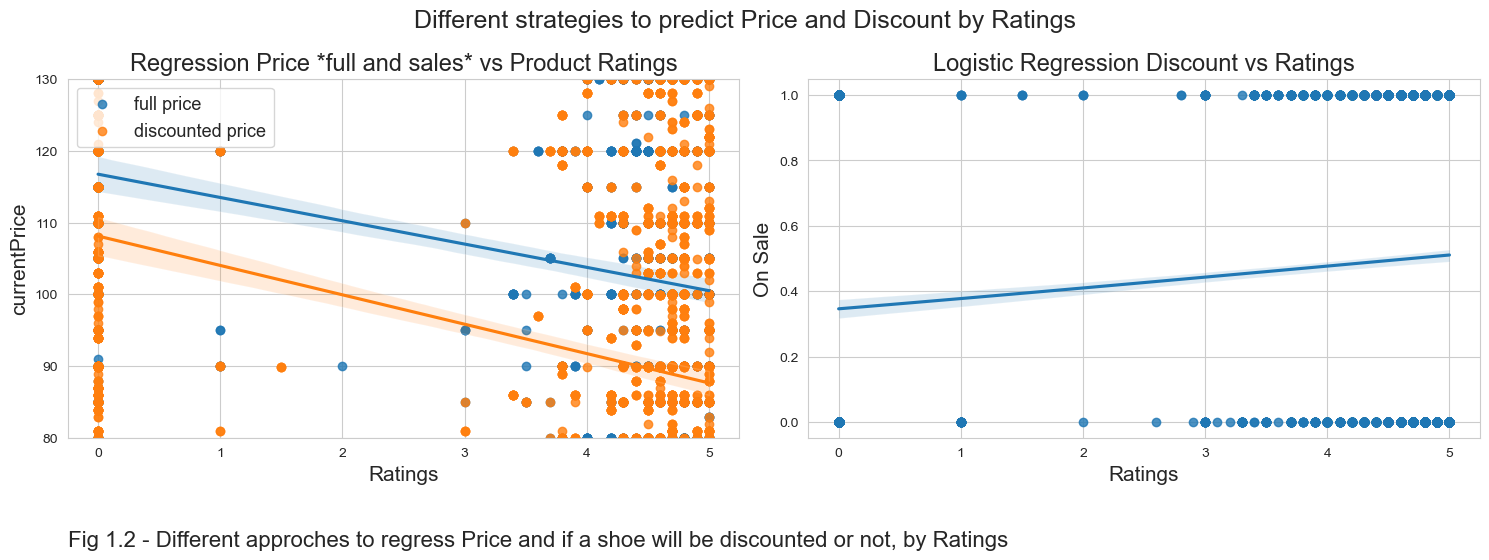

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax=ax.ravel()
sns.set_style('white')

sns.regplot(data=df, x='rating', y='fullPrice', label='full price', ax=ax[0])
sns.regplot(data=df, x='rating', y='currentPrice', label='discounted price', ax=ax[0])
ax[0].set_title('Regression Price *full and sales* vs Product Ratings',fontsize=17)
ax[0].set_ylim(80, 130)
ax[0].legend(loc='upper left',fontsize=13)
ax[0].set_xlabel('Ratings',fontsize=15)
ax[0].set_ylabel('currentPrice',fontsize=15)

sns.regplot(data=df, x='rating', y='sale', logistic=True, ax=ax[1])
ax[1].set_title('Logistic Regression Discount vs Ratings',fontsize=17)
ax[1].set_xlabel('Ratings',fontsize=15)
ax[1].set_ylabel('On Sale',fontsize=15)

# sns.regplot(data=df, y='sale', x='rating', lowess=True, ax=ax[2])
# ax[2].set_title('Scatter plot for On Sale vs Product Ratings (lowess)',fontsize=17)
# ax[2].set_xlabel('Ratings',fontsize=15)
# ax[2].set_ylabel('On Sale',fontsize=15)

plt.suptitle('Different strategies to predict Price and Discount by Ratings',fontsize=18)

plt.tight_layout()
ax[0].annotate(f'Fig 1.2 - Different approches to regress Price and if a shoe will be discounted or not, by Ratings', 
               xy = (0, -.3),xycoords='axes fraction', ha='left',  fontsize=16)


plt.plot();

### Shoe distribution among categories

Figure 1.3 shows the distribution of shoes across different classes. We observe that the lifestyle category has the highest frequency, while the Jordan category is the second smallest.

Consistent with our previous findings, for each segment, the subcategory for men has the highest number of shoes. This information can help us to understand the preferences and buying habits of different customer groups, and can inform our marketing and product development strategies.

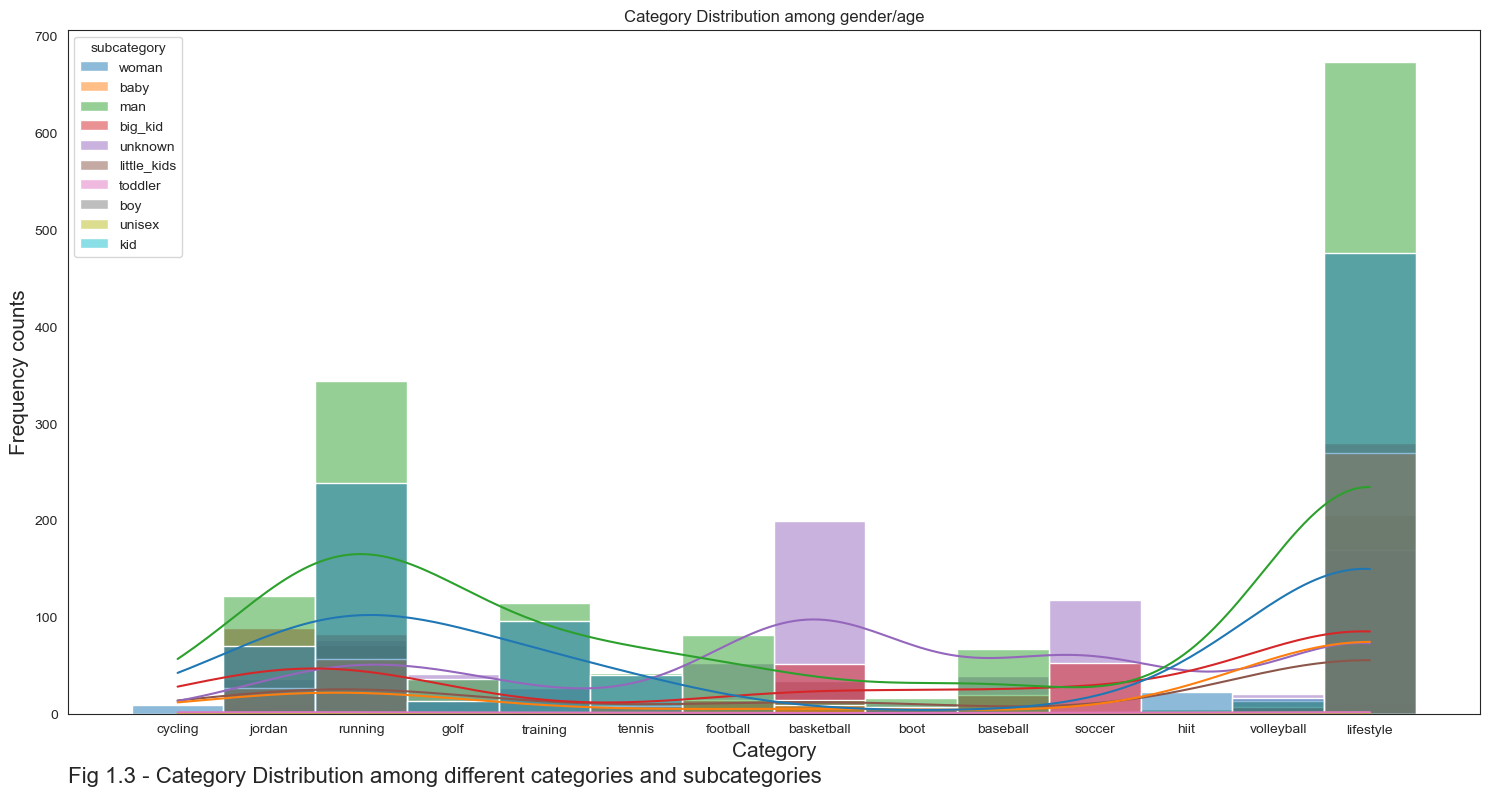

In [16]:
# Ploting distribution
warnings.filterwarnings("ignore")
fig = plt.figure(figsize=(15,8))
# sns.set(font_scale=2)

plt.title('Category Distribution among gender/age')
sns.histplot(data=df, x='category', hue='subcategory', kde=True)
plt.xlabel('Category', fontsize=15)
plt.ylabel('Frequency counts', fontsize=15)

plt.annotate(f'Fig 1.3 - Category Distribution among different categories and subcategories', 
               xy = (0, -.1),xycoords='axes fraction', ha='left',  fontsize=16)

plt.tight_layout()
plt.show();


### SubTask 2: Feature Engineering


In this subtask, we will be performing feature engineering to create new features and refine existing ones in order to improve the performance of our predictive models. 

One key aspect of this process will be to evaluate the number of unique values for each feature in our dataset, as this can help us to identify potential issues such as class imbalance or highly correlated variables. 

We will use this information to decide which features to include or exclude from our models, and how to pre-process and transform the data in order to maximize its predictive power.

In [17]:
# How many unique values do we have?
print_msg('Unique Values for initial DataFrame')
display(df.iloc[:,2:].nunique())
print_msg('\nTable 1.2 - several fields with only one unique value, can be dropped.', side='',marquee=False)

-----------------------------------------
*  Unique Values for initial DataFrame  *
-----------------------------------------


title                     860
subtitle                  188
category                   14
type                        1
currency                    1
fullPrice                  72
currentPrice              187
sale                        2
TopColor                 1119
channel                     3
short_description        1334
rating                     28
customizable                1
ExtendedSizing              1
inStock                     2
ComingSoon                  1
BestSeller                  2
Excluded                    1
GiftCard                    1
Jersey                      1
Launch                      1
MemberExclusive             2
NBA                         1
NFL                         1
Sustainable                 2
label                       5
prod_url                 1523
color-ID                 4415
color-Description        2816
color-FullPrice            75
color-CurrentPrice        216
color-Discount              2
color-BestSeller            2
color-InSt


Table 1.2 - several fields with only one unique value, can be dropped.


---
#### We can delete all fields with single value, because they don't have information

Several fields in our dataset have only one unique value, which indicates that they may not provide useful information for our predictive models. 
 
These fields can be dropped from the dataset to avoid introducing noise and reducing the overall predictive power of our models. By removing these redundant fields, we can focus on the features that are most relevant and informative for our analysis. This will help us to build more accurate and effective models for predicting shoe prices and discounts.

In [18]:
# we can delete all fields with a single value, because they don't have information
df.drop(['type','currency','customizable','ExtendedSizing','BestSeller','Excluded','NFL','NBA','Launch','Jersey','GiftCard'],axis=1, inplace=True)

---
#### What is the variance for flag predictors at the Shoe Level?

In [19]:
# Also, there are several predictors at the TopColor shows only the first color of the model, we don't need this column
print_msg('Variance of TopColor Decription versus Color-Description (color at shoe level)')
display(df.loc[:10][['TopColor','colorNum','color-Description']])
print_msg('Table 1.3 - Color description is repeated at the shoe level.',side='', marquee=False)

------------------------------------------------------------------------------------
*  Variance of TopColor Decription versus Color-Description (color at shoe level)  *
------------------------------------------------------------------------------------


,TopColor,colorNum,color-Description
0,Black/Anthracite/Habanero Red/Phantom,1,Black/Anthracite/Habanero Red/Phantom
1,Black/Anthracite/Habanero Red/Phantom,2,Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...
2,Black/Anthracite/Habanero Red/Phantom,3,White/Black
3,Black/Anthracite/Habanero Red/Phantom,4,Black/Hyper Crimson/Metallic Silver
4,Black/Anthracite/Habanero Red/Phantom,5,White/Black/Chutney/Volt
5,Black/Anthracite/Habanero Red/Phantom,6,Green Glow/Infinite Lilac/Laser Orange/Dark Sm...
6,Black/Volt/Anthracite/White,1,Black/Volt/Anthracite/White
7,Black/Volt/Anthracite/White,2,Crimson Bliss/Total Orange/Pearl White
8,Black/Volt/Anthracite/White,3,White/Mint Foam/Laser Blue/Black


Table 1.3 - Color description is repeated at the shoe level.


In [20]:
# We don't drop TopColor, as we use it later in the model. 
# Dropping prod and image URLs, no needed for prediction (but they will be used in CNN model to donwload images)
df.drop(['prod_url','color-Image-url'],axis=1, inplace=True)

### Dataframe looks better after all cleansing: no predictors with a single value at color level

In [21]:
# this looks better, no predictors with a single value
print_msg('Dataframe unique value counts')
display(df.iloc[:,2:].nunique())
print_msg('\nTable 1.4 - There are no no more fields with single value in the dataframe.', side='',marquee=False)

-----------------------------------
*  Dataframe unique value counts  *
-----------------------------------


title                     860
subtitle                  188
category                   14
fullPrice                  72
currentPrice              187
sale                        2
TopColor                 1119
channel                     3
short_description        1334
rating                     28
inStock                     2
ComingSoon                  1
MemberExclusive             2
Sustainable                 2
label                       5
color-ID                 4415
color-Description        2816
color-FullPrice            75
color-CurrentPrice        216
color-Discount              2
color-BestSeller            2
color-InStock               2
color-MemberExclusive       2
color-New                   2
color-Label                 6
subcategory                10
dtype: int64


Table 1.4 - There are no no more fields with single value in the dataframe.


### We have several predictors at the Product Level and also at Color Level. 
Let's analyze if we need both and see if there are discounted shoes with no discount at color level

We have several predictors at both the product level and the color level in our dataset. We need to  evaluate whether we need both sets of predictors, and whether there are discounted shoes that have no discount at the color level. 

In [22]:
discounted = df[df['sale']==True]
idx = discounted[discounted['color-Discount']==False]['shortID']

print_msg('Fields at shoe and color-level could be different')
display(df[df['shortID'].isin(idx)][['title','colorNum','fullPrice','sale','color-Discount','color-CurrentPrice']])
print_msg('\nTable 1.5 - Shoes with different colors can have different values for specific colors (e.g. discount for specific colors).', side='',marquee=False)

-------------------------------------------------------
*  Fields at shoe and color-level could be different  *
-------------------------------------------------------


,title,colorNum,fullPrice,sale,color-Discount,color-CurrentPrice
141,Air Jordan 11 CMFT Low,1,130,True,True,110.97
142,Air Jordan 11 CMFT Low,2,130,True,False,130.00
143,Air Jordan 11 CMFT Low,3,130,True,False,130.00
144,Air Jordan 11 CMFT Low,4,130,True,False,130.00
178,Jordan Air 200E,1,125,True,True,87.97
...,...,...,...,...,...,...
4677,Nike Presto,4,105,True,True,76.97
4717,Nike Air Max Bolt,1,70,True,True,52.97
4718,Nike Air Max Bolt,2,70,True,False,70.00
4756,Nike Air Force 1 Mid React,1,150,True,True,127.97



Table 1.5 - Shoes with different colors can have different values for specific colors (e.g. discount for specific colors).


#### Is the opposite true? are there shoes flagged as not discounted, but with discounted at color level?

In [23]:
discounted = df[df['sale']==False]
idx = discounted[discounted['color-Discount']==True]['shortID']

print_msg('More discrepancies between color and shoe level')
display(df[df['shortID'].isin(idx)][['title','colorNum','fullPrice','sale','color-Discount','color-CurrentPrice']])
print_msg('\nTable 1.6 - Shoe discrepancies goes both ways: shoe flagged with no discount, but that have colors with discounted price).', side='',marquee=False)

-----------------------------------------------------
*  More discrepancies between color and shoe level  *
-----------------------------------------------------


,title,colorNum,fullPrice,sale,color-Discount,color-CurrentPrice
52,Jordan Max Aura 4,1,125,False,False,125.00
53,Jordan Max Aura 4,2,125,False,False,125.00
54,Jordan Max Aura 4,3,125,False,True,106.97
55,Jordan Max Aura 4,4,125,False,False,125.00
56,Jordan Max Aura 4,5,125,False,False,125.00
...,...,...,...,...,...,...
4732,Nike Air Max Axis,2,80,False,True,54.97
4739,Nike Air Max Thea Mid,2,150,False,True,127.97
4775,Nike Force 1 Crater Next Nature,1,60,False,False,60.00
4776,Nike Force 1 Crater Next Nature,2,60,False,True,50.97



Table 1.6 - Shoe discrepancies goes both ways: shoe flagged with no discount, but that have colors with discounted price).


### Dropping Redundatn Predictors

fter conducting our analysis, we have determined that the sale indicator at the product level is redundant and can be dropped. Instead, we will use the discount indicator at the color level, as it has more predictive power. We will also use the current price and full price at the color level, as these values are more detailed. 

Additionally, we have found that the "label" predictor is redundant, as we already have the "color-label" predictor.

In [24]:
# Before Droping, creating extra flags at color level, for label

#lets add label "JustIn" and remove color-label
df['color-just_in']=False
df['color-just_in'] = np.where(df['color-Label'] == 'JUST_IN', True, False)

# Add column Sold Out
df['color-sold_out'] = False
df['color-sold_out'] = np.where(df['color-Label'] == 'SOLD_OUT', True, False)

# Add column In Stock
df['color-coming_soon'] = False
df['color-coming_soon'] = np.where(df['color-Label'] == 'COMING_SOON', True, False)

# Droping redundant labels at Shoe Level
df.drop(['sale','label','inStock','MemberExclusive','ComingSoon','color-Label'], axis=1, inplace=True)

#### What about channels? this is a categorical variable, we need to take care of it. 

Table 1.7 shows that channels are redundant and can be condensed into two categorical variables. We do that.

In [25]:
display(pd.DataFrame(df['channel'].unique(), columns=['Unique Channels']))
print_msg('\nTable 1.7 - Unique sales channels, these values can be encoded as categorical variables.', side='',marquee=False)

,Unique Channels
0,"['NikeApp', 'Nike.com', 'Nike Store Experiences']"
1,"['SNKRS', 'NikeApp', 'Nike.com', 'Nike Store E..."
2,"['Nike.com', 'Nike Store Experiences']"



Table 1.7 - Unique sales channels, these values can be encoded as categorical variables.


In [26]:
# Add channel SNKRS
df['channel_SNKRS'] = False
df['channel_SNKRS'] = np.where(df['channel'] == "['SNKRS', 'NikeApp', 'Nike.com', 'Nike Store Experiences']", True, False)

In [27]:
# Add channel nikeApp
df['channel_nikeApp'] = False
df['channel_nikeApp'] = np.where(df['channel'] == "['NikeApp', 'Nike.com', 'Nike Store Experiences']", True, False)

In [28]:
# And we can delete channel, and the IDs for Product and Color 
df.drop(['channel'],axis=1, inplace=True)
df.drop(['shortID','color-ID'], axis=1,inplace=True)

### Finally, our data is ready to tokenize - lets take a last look into it

After completing our data cleaning and feature engineering processes, our data is now ready for tokenization. Before we proceed, let's take one final look at the dataset to ensure that it is ready for this next step.

Table 1.7 shows a summary of the engineered features, for a total of 4,677 rows and 24 columns.

In [29]:
print_msg('Dataframe Clean and Consistent')
display(df.info())

print_msg('\nTable 1.7 - Data ready to be tokenized, no nulls, no uniques', side='',marquee=False)

display(df.head())

print_msg('\nTable 1.7 - Data ready to be tokenized, no nulls, no uniques', side='',marquee=False)


------------------------------------
*  Dataframe Clean and Consistent  *
------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4677 entries, 0 to 4843
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   colorNum               4677 non-null   int64  
 1   title                  4677 non-null   object 
 2   subtitle               4677 non-null   object 
 3   category               4677 non-null   object 
 4   fullPrice              4677 non-null   int64  
 5   currentPrice           4677 non-null   float64
 6   TopColor               4677 non-null   object 
 7   short_description      4677 non-null   object 
 8   rating                 4677 non-null   float64
 9   Sustainable            4677 non-null   bool   
 10  color-Description      4677 non-null   object 
 11  color-FullPrice        4677 non-null   float64
 12  color-CurrentPrice     4677 non-null   float64
 1

None


Table 1.7 - Data ready to be tokenized, no nulls, no uniques


,colorNum,title,subtitle,category,fullPrice,currentPrice,TopColor,short_description,rating,Sustainable,color-Description,color-FullPrice,color-CurrentPrice,color-Discount,color-BestSeller,color-InStock,color-MemberExclusive,color-New,subcategory,color-just_in,color-sold_out,color-coming_soon,channel_SNKRS,channel_nikeApp
0,1,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,120,58.97,Black/Anthracite/Habanero Red/Phantom,The Nike SuperRep Cycle brings a breathable de...,4.3,False,Black/Anthracite/Habanero Red/Phantom,120.0,58.97,True,False,True,False,False,woman,False,False,False,False,True
1,2,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,120,58.97,Black/Anthracite/Habanero Red/Phantom,The Nike SuperRep Cycle brings a breathable de...,4.3,False,Archaeo Pink/Metallic Mahogany/Dark Beetroot/L...,120.0,84.97,True,False,True,False,False,woman,False,False,False,False,True
2,3,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,120,58.97,Black/Anthracite/Habanero Red/Phantom,The Nike SuperRep Cycle brings a breathable de...,4.3,False,White/Black,120.0,84.97,True,False,True,False,False,woman,False,False,False,False,True
3,4,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,120,58.97,Black/Anthracite/Habanero Red/Phantom,The Nike SuperRep Cycle brings a breathable de...,4.3,False,Black/Hyper Crimson/Metallic Silver,120.0,58.97,True,False,True,False,False,woman,False,False,False,False,True
4,5,Nike SuperRep Cycle,Women's Indoor Cycling Shoes,cycling,120,58.97,Black/Anthracite/Habanero Red/Phantom,The Nike SuperRep Cycle brings a breathable de...,4.3,False,White/Black/Chutney/Volt,120.0,72.97,True,False,True,False,False,woman,False,False,False,False,True



Table 1.7 - Data ready to be tokenized, no nulls, no uniques


<a id="part2"></a>
## STEP 2: Text Preprocessing (tokenization) and text Vectorization

In this section, we will be using a two-step approach to preprocess and vectorize our text data. This will involve:

Reducing words using Gensim's preprocess_string utility, along with stopwords and tokenization.
Vectorizing the resulting tokens using the CountVectorizer utility from scikit-learn, to create a sparse matrix representation of the text data.

This process will help us to convert our text data into a sparse matrix format that can be used as input to our predictive models.


### Logic for Tokenizing, Vectorizing, and spliting data 

For text preprocessing, we are using a pseudo-stem pre-process from library gensum: *preprocess_string*

In [30]:
def tokenize(column, df, method="stem"):
    '''
    Tokenize each column with a specified method
    ''' 
    
    # Tokenization using gensum stem
    if method == 'stem':
        column_tok = df[column].apply(lambda x: ' '.join(preprocess_string(x)))        
    else:
        column_tok = df[column].apply(lambda x: ' '.join(simple_preprocess(x)))  

    # Vectorization using CountVectorizer
    vect = CountVectorizer(stop_words='english').fit(column_tok)

    new_cols = pd.DataFrame(
        vect.transform(df[column]).toarray(),
        columns=[f'{column}_{feature}' for feature in vect.get_feature_names_out()],
        index=df.index
    )

    df = pd.concat([df, new_cols], axis=1)
    df = df.drop(columns=[column])
    
    return df

# Then we get X and y 
def vectorize(df, method='stem',
              txt_cols=['title','subtitle', 'short_description', 'color-Description', 'category','TopColor']):
    '''
    Vectorize the given dataframe with either short or regular text-preprocessing method:
    
        df: dataframe to vectorize
        method: simple or stem (stem is shorter)
        columns: these are the columns that will be tokenized
    '''    
    # Columns to be tokenized 
    df_copy = df.copy()

    for column in txt_cols:
        df_copy = tokenize(column, df_copy, method=method)
        
    return df_copy

In [31]:
def getX(df, full_price=True, random_state=109):
    '''
    Split dataset into Train, Validation and Test
    '''
    # Then we get X and Y accordingly
    if full_price: 
        y = df['fullPrice']
    else:          
        y = df['currentPrice']       

    X = df.drop(['color-FullPrice','color-CurrentPrice','color-Discount','fullPrice','currentPrice'], axis=1)

    # And we split in train, validation and test datasets    
    # First we held test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # then we split Train again to get Validation and Train
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=random_state)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

#### Reducing words and getting vectors

We use the above functions to perform text pre-processing, word reduction, and vectorization. Also, we split our data into our feature matrix (X) and the response variable (Y)

from above information, we observe that the new feature matrix has expanded to 4,562 new features, due to the vectorization process.

In [32]:
df = vectorize(df,'stem')
# Use this to remove categorical variables
df = pd.get_dummies(df,columns=['subcategory'])

my_msg=f'total tokenized and vectorized features {df.shape[1]}'

print_msg(my_msg)

--------------------------------------------------
*  total tokenized and vectorized features 4562  *
--------------------------------------------------


#### Spliting Train, Val, and Test datasets

Now we are ready to split our data into Trainining, validation and test datasets.

We are going to held 20% of our data for testing, and the remaining data will be splitted 80% for Training and 20% for Validation.

In [33]:
random_state=109

# For Y=FullPrice or CurrentPrice, set "full_price" input parameter
X_train, X_val, X_test, y_train, y_val, y_test = getX(df, full_price=True, random_state=random_state)


print_msg(f'total features per token preprocessing method: {X_train.shape[1]}')

test_per = X_test.shape[0]/df.shape[0]*100
train_per  = round(X_train.shape[0]/df.shape[0]*100,2)
val_per = round(X_val.shape[0]/df.shape[0]*100,2)

print(f'Total rows: {df.shape[0]}')
print(f'Test {X_test.shape[0]} rows [{test_per}%]')
print(f'Train {X_train.shape[0]} rows [{train_per}%]') 
print(f'Validation {X_val.shape[0]} rows [{val_per}%]')

---------------------------------------------------------
*  total features per token preprocessing method: 4557  *
---------------------------------------------------------
Total rows: 4677
Test 936 rows [20.012828736369467%]
Train 2992 rows [63.97%]
Validation 749 rows [16.01%]


In [34]:
print_msg(f'X_train shape: {X_train.shape}')
display(X_train.head())
print_msg('\nTable 2.1 -Show dataframe description.', side='',marquee=False)

---------------------------------
*  X_train shape: (2992, 4557)  *
---------------------------------


,colorNum,rating,Sustainable,color-BestSeller,color-InStock,color-MemberExclusive,color-New,color-just_in,color-sold_out,color-coming_soon,channel_SNKRS,channel_nikeApp,title_ac,title_academi,title_access,title_acclim,title_acg,title_adapt,title_adg,title_adjust,title_advanc,title_air,title_alpha,title_alphafli,title_alta,title_ambush,title_amp,title_angel,title_aqua,title_arcadia,title_asuna,title_aura,title_axi,title_bai,title_basebal,title_basic,title_bear,title_bella,title_benassi,title_betru,title_blazer,title_bliss,title_blue,title_blzr,title_boa,title_bolt,title_borough,title_bowerman,title_break,title_breath,...,TopColor_thunder,TopColor_tint,TopColor_topaz,TopColor_total,TopColor_tour,TopColor_trail,TopColor_tranc,TopColor_treasur,TopColor_treelin,TopColor_true,TopColor_turbo,TopColor_turquois,TopColor_twine,TopColor_twist,TopColor_univers,TopColor_vachetta,TopColor_valerian,TopColor_vanilla,TopColor_vapor,TopColor_varsiti,TopColor_velvet,TopColor_venic,TopColor_venom,TopColor_vintag,TopColor_violet,TopColor_viotech,TopColor_vivid,TopColor_volt,TopColor_voltag,TopColor_wash,TopColor_wave,TopColor_wheat,TopColor_whisper,TopColor_white,TopColor_wild,TopColor_wolf,TopColor_worn,TopColor_wow,TopColor_yellow,TopColor_zen,subcategory_baby,subcategory_big_kid,subcategory_boy,subcategory_kid,subcategory_little_kids,subcategory_man,subcategory_toddler,subcategory_unisex,subcategory_unknown,subcategory_woman
3454,4,4.6,False,False,True,False,False,False,False,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1074,2,0.0,False,False,True,False,False,False,False,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2826,6,4.5,True,False,True,False,False,False,False,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2555,2,4.6,False,True,True,False,False,False,False,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4755,1,5.0,False,False,True,False,False,False,False,False,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0



Table 2.1 -Show dataframe description.


## Baseline Model

To establish a baseline for our predictive models, we will build a simple model using the Random Forest algorithm. This will help us to select the best model for our data and use case.

Table 2.2 shows that our baseline has a good initial performance. It seems that the vectorization is working.

In [35]:
print_msg(f'Baseline Random Forest Tree')
start_time = datetime.now()
print(start_time)

estimators = 100
best_depth = 40

rf = RandomForestRegressor(n_estimators=estimators,
                          max_depth=best_depth).fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
y_val_pred = rf.predict(X_val)

print(f'''\nBaseline Random forest: 
   depth={best_depth} 
   number estimators={estimators} 
   number of total features={X_train.shape[1]}
''')
print(f'MSE Train: {mse(y_train, y_train_pred).round(4)} Validation: {mse(y_val, y_val_pred).round(4)}')
print(f'MAE Train {mae(y_train, rf.predict(X_train)).round(4)} Validation: {mae(y_val, rf.predict(X_val)).round(4)}\n')

end_time = datetime.now()
print(f'{end_time}\nelapsed time {end_time - start_time}\n')
print_msg('\nTable 2.2 - Model Baseline using a Random Forest decision tree.', side='',marquee=False)



---------------------------------
*  Baseline Random Forest Tree  *
---------------------------------
2022-12-11 14:54:40.723025

Baseline Random forest: 
   depth=40 
   number estimators=100 
   number of total features=4557

MSE Train: 21.7718 Validation: 127.9919
MAE Train 2.1656 Validation: 5.1063

2022-12-11 14:55:07.895679
elapsed time 0:00:27.172654


Table 2.2 - Model Baseline using a Random Forest decision tree.


<a id="part3"></a>
## STEP 3: Feature Selection Using Lasso

#### Using crossvalidaton (CV=5 and alpha 0.01 to 0.8) - WARINING-takes around 10 mins to run

In this step, we will use Lasso regression to select the most relevant and informative features in our dataset. We will use cross-validation with 5 folds, and a range of alpha values from 0.01 to 0.8. By using Lasso in conjunction with cross-validation, we can ensure that our feature selection process is robust and reliable. 

This process can be computationally intensive, so please be aware that it may take up to 10 minutes to run.

In [36]:
pipeline = Pipeline([('model',Lasso(max_iter=10000))])

search = GridSearchCV(pipeline, 
                     {'model__alpha':np.arange(0.01,1,0.1)},
                     cv = 5,
                     scoring='neg_mean_squared_error', 
                     verbose=1, 
                     n_jobs= 5
                     )

In [37]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', Lasso(max_iter=10000))]),
             n_jobs=5,
             param_grid={'model__alpha': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91])},
             scoring='neg_mean_squared_error', verbose=1)

In [38]:
print_msg('Best Results from Lasso Regression')

print(f'Best alpha={search.best_params_}')
print(f'Best MSE={-(search.best_score_)}')

----------------------------------------
*  Best Results from Lasso Regression  *
----------------------------------------
Best alpha={'model__alpha': 0.01}
Best MSE=205.83530912511424


#### Top 30 Features Selected by Lasso Regression

Fig.3.1 lists the first 30 features, ranked in order of importance (according to Lasso)


In [39]:
# Get Features' Names
features = X_train.columns
     
# Get all coefficients for importance
coefficients = search.best_estimator_.named_steps['model'].coef_

# Get importance as a numerical value
importance = np.abs(coefficients)

# puting togeter features and numerical importance
feature_imporantance_df = pd.DataFrame(list(zip(features, importance)), columns=['feature','importance'])
weighted_features = feature_imporantance_df.sort_values(by='importance', ascending=False)

# let's see our dataframe now
critical_features = weighted_features[weighted_features['importance']> 0]

my_feat_msg=f'''* Total features: {len(features)}, Number of Features with Importance > 0 : [{len(critical_features)}]*
                 List of first 30 most important features'''
print_msg(my_feat_msg, char='', side='')
display(weighted_features.head(30))
print_msg('Table 3.1: List of features in importance order, according to Lasso Regression', side='', marquee=False)


  * Total features: 4557, Number of Features with Importance > 0 : [771]*
                 List of first 30 most important features  



,feature,importance
2102,short_description_marathon,101.476307
1059,short_description_cover,96.152228
457,subtitle_firm,90.113011
89,title_dbreak,71.411117
1927,short_description_kangaroo,60.053744
37,title_bella,59.131387
1618,short_description_gira,54.259847
2847,short_description_shave,51.340075
266,title_offcourt,49.177364
3623,short_description_zonal,48.380030


Table 3.1: List of features in importance order, according to Lasso Regression


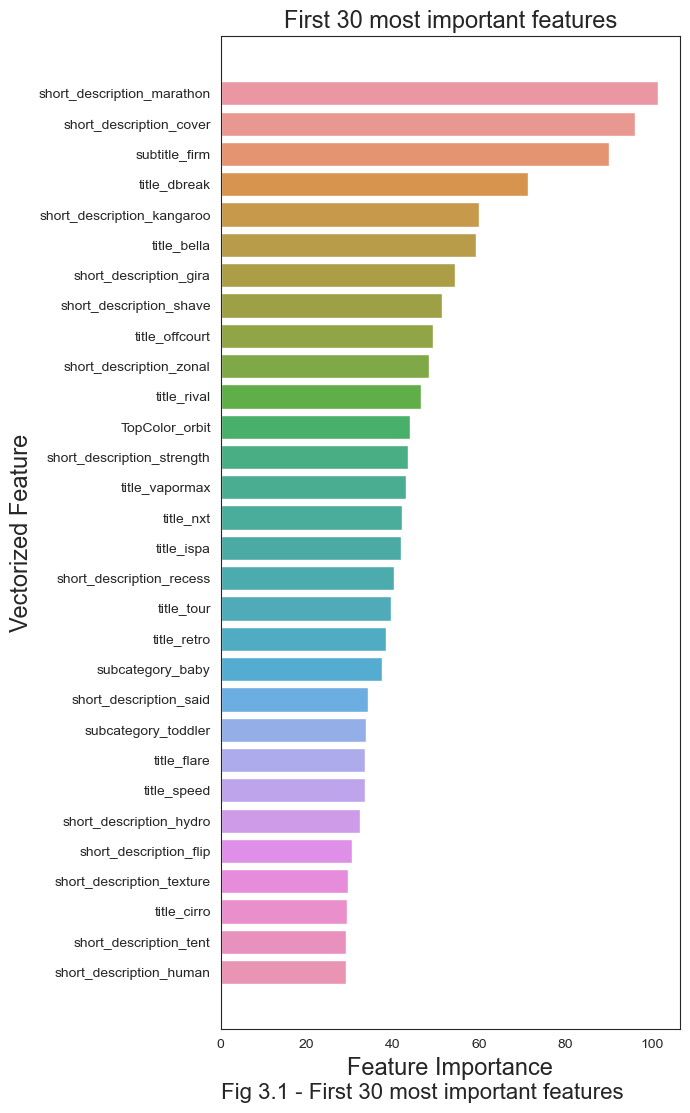

In [40]:
max_importance=30
fig = plt.figure(figsize=(7,11))
sns.barplot(data=weighted_features.head(max_importance), y='feature', x='importance')
plt.xlabel('Feature Importance', fontsize=17)
plt.ylabel('Vectorized Feature', fontsize=17)
plt.title(f'First {max_importance} most important features',fontsize=17)

plt.tight_layout()
plt.annotate(f'Fig 3.1 - First 30 most important features', 
               xy = (0, -.07),xycoords='axes fraction', ha='left',  fontsize=16)

plt.plot();

<a id="part4"></a>
## STEP 4: Hyperparameter tunning

#### Best Depth, Feature Selection, and Number of Estimators

In this step, we will be tuning the hyperparameters of our predictive models. Involves optimizing **best max depth, feature selection, and number of estimators** for our models.

We will use a combination of manual tuning and grid search to explore the parameter space and find the optimal values for each hyperparameter. This will involve training and evaluating multiple models with different combinations of hyperparameters, and selecting the best-performing models based on their predictive accuracy and performance.

---

### Tuning the Max Depth with a Single Decision Tree
In this section, we will tune the max depth of our predictive model using a single decision tree and cross-validation. By optimizing the max depth, we can ensure that our model is not overfitting or underfitting the data.

To tune the max depth, we will train multiple decision trees with different values for the max depth parameter, and evaluate their performance using cross-validation.

In [41]:
# Retrieves the full name of features 
features = X_train.columns

In [42]:
critical_features = weighted_features[weighted_features['importance']> 1]
filtro_lasso = list(critical_features.feature)
X_train_lasso = X_train[filtro_lasso].copy()
X_val_lasso = X_val[filtro_lasso].copy()
dt_max_depth = 100
dt_cv = 5
cvmeans, cvstds, train_scores = [],[],[]

for depth in tqdm(range(1, dt_max_depth + 1)):  
    dt_tree = DecisionTreeRegressor(max_depth=depth).fit(X_train_lasso, y_train)
    
    # Getting "regular" scores
    train_scores.append(dt_tree.score(X_train_lasso, y_train))
    
    # then, using cross-validation
    dt_score = cross_val_score(estimator=dt_tree, cv=dt_cv, X=X_train_lasso, y=y_train, 
                               scoring='neg_mean_squared_error',
)
    
    cvmeans.append(-1*np.mean(dt_score))
    cvstds.append(np.std(dt_score))  
    
best_depth = np.argmin(cvmeans)
print(f'BEST DEPTH: {best_depth}')

100%|█████████████████████████████████████████| 100/100 [00:58<00:00,  1.72it/s]

BEST DEPTH: 88


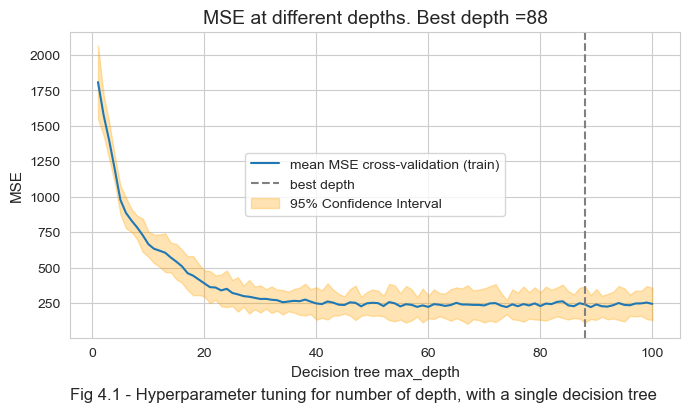

In [43]:
# your code here 
dt_max_depth = 100
fig = plt.figure(figsize=(7,4))

q12_X = np.arange(1, dt_max_depth + 1)
cvmeans=np.array(cvmeans)

# get confidence interval
ci = 2*np.array(cvstds)

sns.set_style('whitegrid')
sns.lineplot(x=q12_X, y=cvmeans, label='mean MSE cross-validation (train)')
plt.axvline(x=best_depth, color='grey', ls='--', label='best depth')
plt.fill_between(q12_X, cvmeans - ci, cvmeans + ci, 
                         color = 'orange', alpha=0.3, label='95% Confidence Interval')
plt.ylabel('MSE',fontsize=11)
plt.xlabel('Decision tree max_depth',fontsize=11)
plt.legend(loc='center', fontsize=10)
plt.title(f'MSE at different depths. Best depth ={best_depth}',fontsize=14)

plt.tight_layout()
plt.annotate(f'Fig 4.1 - Hyperparameter tuning for number of depth, with a single decision tree', 
               xy = (0, -.2),xycoords='axes fraction', ha='left',  fontsize=12)

plt.show();

### Determining the Best Number of Features using Lasso Coefficients and CV

We use cross-validation to evaluate the performance of our model with different numbers of Lasso features, ranging from the top-ranked features to all features in the dataset.By using Lasso regression and cross-validation together, we can find the optimal number of features that produces the best-performing model.

In [44]:
print(datetime.now())
# Empirically we found that twice the value renders better results for feature selection
# best_depth = best_depth*2

numFeatures,mse_train, mse_val, mae_train, mae_val = [], [], [], [], []
num_features = []
importances = [0, 1, 2, 3, 4, 5, 6, 7]

for max_importance in tqdm(importances, desc='feature importance'):  
    crit_f = weighted_features[weighted_features['importance'] > max_importance]
    filtro = list(crit_f.feature)
    
    X_train_filtro = X_train[filtro]
    X_val_filtro = X_val[filtro]

    rf = RandomForestRegressor(n_estimators=100,
                               max_depth=best_depth).fit(X_train_filtro, y_train)

    y_train_pred = rf.predict(X_train_filtro)
    y_val_pred   = rf.predict(X_val_filtro)
    
    mse_train_i= mse(y_train_pred, y_train).round(4)
    mse_val_i  = mse(y_val_pred, y_val).round(4) 
    
    mae_train_i= mae(y_train, rf.predict(X_train_filtro)).round(4)
    mae_val_i  = mae(y_val,   rf.predict(X_val_filtro)).round(4)
    
    print(f'\nNumber of Features={X_train_filtro.shape[1]}, max importance threshold > {max_importance}')
    print(f'\tMSE Train {mse_train_i} , Val {mse_val_i}')
    print(f'\tMAe Train {mae_train_i}, Val {mae_val_i}')

    num_features.append(X_train_filtro.shape[1])
    mse_train.append(mse_train_i)
    mse_val.append(mse_val_i)
    mae_train.append(mae_train_i)
    mae_val.append(mae_val_i)

print(datetime.now())

importance_threshold = importances[np.argmin(mae_val)]
best_num_features = num_features[importance_threshold]
print(f"Best Feature Importance Trhreshold {importance_threshold} for {best_num_features} features")

2022-12-11 14:57:31.218814


feature importance:  12%|███▏                     | 1/8 [00:10<01:11, 10.18s/it]


Number of Features=771, max importance threshold > 0
	MSE Train 18.0546 , Val 120.6525
	MAe Train 1.8447, Val 4.8179


feature importance:  25%|██████▎                  | 2/8 [00:17<00:50,  8.47s/it]


Number of Features=600, max importance threshold > 1
	MSE Train 18.4072 , Val 111.9387
	MAe Train 1.6999, Val 4.2441


feature importance:  38%|█████████▍               | 3/8 [00:23<00:35,  7.16s/it]


Number of Features=509, max importance threshold > 2
	MSE Train 17.0286 , Val 103.7075
	MAe Train 1.6636, Val 3.9635


feature importance:  50%|████████████▌            | 4/8 [00:27<00:24,  6.08s/it]


Number of Features=438, max importance threshold > 3
	MSE Train 17.0809 , Val 104.5736
	MAe Train 1.689, Val 4.0123


feature importance:  62%|███████████████▋         | 5/8 [00:31<00:16,  5.39s/it]


Number of Features=386, max importance threshold > 4
	MSE Train 16.9259 , Val 109.5984
	MAe Train 1.6898, Val 4.1309


feature importance:  75%|██████████████████▊      | 6/8 [00:35<00:09,  4.81s/it]


Number of Features=329, max importance threshold > 5
	MSE Train 18.0251 , Val 113.2109
	MAe Train 1.8355, Val 4.3502


feature importance:  88%|█████████████████████▉   | 7/8 [00:38<00:04,  4.21s/it]


Number of Features=294, max importance threshold > 6
	MSE Train 19.1086 , Val 102.1768
	MAe Train 1.9547, Val 4.1905


feature importance: 100%|█████████████████████████| 8/8 [00:40<00:00,  5.12s/it]


Number of Features=262, max importance threshold > 7
	MSE Train 25.8449 , Val 111.0114
	MAe Train 2.3448, Val 4.5036
2022-12-11 14:58:12.167590
Best Feature Importance Trhreshold 2 for 509 features


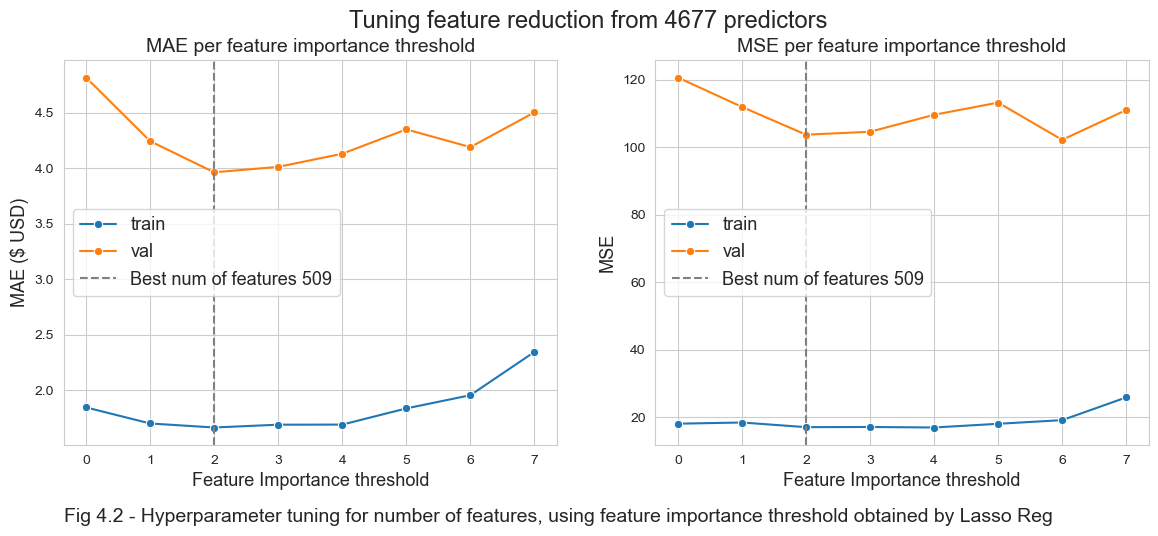

In [45]:
# your code here
X_grid = np.arange(1, len(importances) + 1)

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax = ax.ravel()

sns.lineplot(x=importances, y=mae_train, marker='o', label='train',ax=ax[0])
sns.lineplot(x=importances, y=mae_val, marker='o', label='val',ax=ax[0])
ax[0].axvline(x=importance_threshold, color='grey', ls='--', label=f"Best num of features {best_num_features}")
ax[0].set_title('MAE per feature importance threshold',fontsize=14)
ax[0].set_ylabel('MAE ($ USD)',fontsize=13)
ax[0].set_xlabel('Feature Importance threshold',fontsize=13)
ax[0].legend(loc='center left', fontsize=13)

sns.set_style('whitegrid')
sns.lineplot(x=importances, y=mse_train, marker='o', label='train',ax=ax[1])
sns.lineplot(x=importances, y=mse_val, marker='o', label='val',ax=ax[1])
ax[1].axvline(x=importance_threshold, color='grey', ls='--', label=f"Best num of features {best_num_features}")
ax[1].set_title('MSE per feature importance threshold',fontsize=14)
ax[1].set_ylabel('MSE',fontsize=13)
ax[1].set_xlabel('Feature Importance threshold',fontsize=13)
ax[1].legend(loc='center left',fontsize=13)

plt.suptitle(f'Tuning feature reduction from {df.shape[0]} predictors',fontsize=17)

ax[0].annotate(f'Fig 4.2 - Hyperparameter tuning for number of features, using feature importance threshold obtained by Lasso Reg', 
               xy = (0, -.2),xycoords='axes fraction', ha='left',  fontsize=14)

plt.show();

---
### Checkpoint: Save reduced features to disk

### From what columns the reduced vectorized features are coming from?


In [46]:
# Filtering X' per feature threshold
crit_f = weighted_features[weighted_features['importance'] > importance_threshold]
filtro = list(crit_f.feature)

X_train_filtro = X_train[filtro]
X_val_filtro = X_val[filtro]
X_test_filtro = X_test[filtro]

# Set X's to reduced features
X_train = X_train_filtro
X_val = X_val_filtro
X_test = X_test_filtro

print_msg('Parent columns associated to reduced vectorized features')
set([x.split("_")[0] for x in X_train])

--------------------------------------------------------------
*  Parent columns associated to reduced vectorized features  *
--------------------------------------------------------------


{'Sustainable',
 'TopColor',
 'category',
 'channel',
 'color-Description',
 'color-MemberExclusive',
 'color-sold',
 'short',
 'subcategory',
 'subtitle',
 'title'}

In [47]:
print_msg('Parent subcategory associated to reduced features')
[x for x in X_train.columns if "subcategory_" in x]

-------------------------------------------------------
*  Parent subcategory associated to reduced features  *
-------------------------------------------------------


['subcategory_baby',
 'subcategory_toddler',
 'subcategory_unknown',
 'subcategory_little_kids',
 'subcategory_woman']

In [48]:
# ================== SAFE POINT ==================================
# Change flag at the begining of the notebook
if _SAVE_TO_DISK:
    df.to_csv('data/nike_full_dataframe_vectorized.csv')

    X_train_filtro.to_csv('data/X_train_best.csv')
    X_val_filtro.to_csv('data/X_val_best.csv')
    X_test_filtro.to_csv('data/X_test_best.csv')
    y_train.to_csv('data/y_train.csv')
    y_val.to_csv('data/y_val.csv')

### Determining best number of estimators using a Loop

We iterate to determine the best n_estimator over the Ranfom Forest model

In [49]:
print(datetime.now())
numFeatures,mse_train, mse_val, mae_train, mae_val = [], [], [], [], []
max_estimators = 800

crit_f = weighted_features[weighted_features['importance'] > importance_threshold]
filtro = list(crit_f.feature)
    
X_train_filtro = X_train[filtro]
X_val_filtro = X_val[filtro]

list_of_estimators = np.arange(100,max_estimators,100)

for estimators in tqdm(list_of_estimators, desc='feature importance'):
    rf = RandomForestRegressor(n_estimators=estimators,
                               max_depth=best_depth).fit(X_train_filtro, y_train)

    y_train_pred = rf.predict(X_train_filtro)
    y_val_pred   = rf.predict(X_val_filtro)
    
    mse_train_i= mse(y_train_pred, y_train).round(4)
    mse_val_i  = mse(y_val_pred, y_val).round(4)     
    
    print(f'\n Number of estimators = {estimators} out of {max_estimators}')
    print(f'\tMSE Train {mse_train_i.round(4)} , Val {mse_val_i.round(4)}')
    print(f'\tMAe Train {mae(y_train, rf.predict(X_train_filtro)).round(4)}, Val {mae(y_val, rf.predict(X_val_filtro)).round(4)}')

    mse_train.append(mse_train_i.round(4))
    mse_val.append(mse_val_i.round(4))
    mae_train.append(mae(y_train, rf.predict(X_train_filtro)).round(4))
    mae_val.append(mae(y_val, rf.predict(X_val_filtro)).round(4))

print(datetime.now())

best_estimators = list_of_estimators[np.argmin(mae_val)]
print(f"Best Number of estimators {best_estimators}")

2022-12-11 14:58:12.695626


feature importance:  14%|███▌                     | 1/7 [00:06<00:36,  6.16s/it]


 Number of estimators = 100 out of 800
	MSE Train 16.8308 , Val 102.8769
	MAe Train 1.6666, Val 3.9555

 Number of estimators = 200 out of 800
	MSE Train 17.2992 , Val 102.1994
	MAe Train 1.645, Val 3.9125


feature importance:  29%|███████▏                 | 2/7 [00:16<00:43,  8.78s/it]


 Number of estimators = 300 out of 800
	MSE Train 17.443 , Val 103.1812
	MAe Train 1.6651, Val 3.9709


feature importance:  43%|██████████▋              | 3/7 [00:33<00:49, 12.32s/it]


 Number of estimators = 400 out of 800
	MSE Train 16.6687 , Val 106.6973
	MAe Train 1.6475, Val 4.0079


feature importance:  57%|██████████████▎          | 4/7 [00:54<00:47, 15.78s/it]


 Number of estimators = 500 out of 800
	MSE Train 16.7016 , Val 107.501
	MAe Train 1.6404, Val 4.028


feature importance:  71%|█████████████████▊       | 5/7 [01:20<00:39, 19.55s/it]


 Number of estimators = 600 out of 800
	MSE Train 16.7613 , Val 105.4925
	MAe Train 1.6474, Val 3.9789


feature importance:  86%|█████████████████████▍   | 6/7 [01:52<00:23, 23.66s/it]


 Number of estimators = 700 out of 800
	MSE Train 16.5494 , Val 102.1575
	MAe Train 1.6403, Val 3.9567


feature importance: 100%|█████████████████████████| 7/7 [02:28<00:00, 21.22s/it]

2022-12-11 15:00:41.212079
Best Number of estimators 200


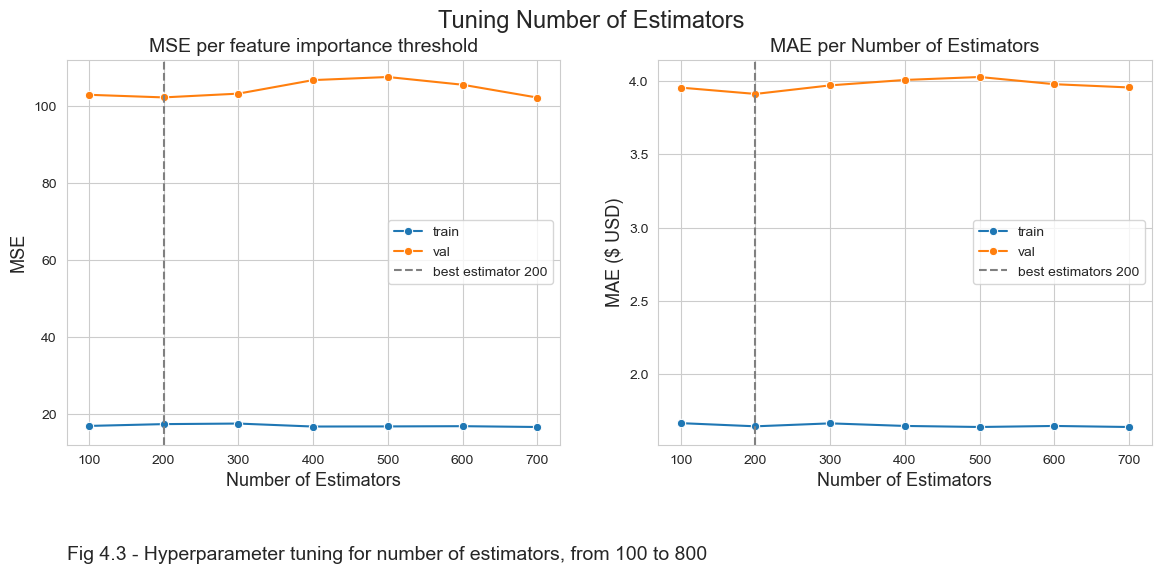

In [50]:
# your code here
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax = ax.ravel()

sns.set_style('whitegrid')
sns.lineplot(x=list_of_estimators, y=mse_train, marker='o', label='train',ax=ax[0])
sns.lineplot(x=list_of_estimators, y=mse_val, marker='o', label='val',ax=ax[0])
ax[0].axvline(x=best_estimators, color='grey', ls='--', label=f'best estimator {best_estimators}')
ax[0].set_title('MSE per feature importance threshold',fontsize=14)
ax[0].set_ylabel('MSE',fontsize=13)
ax[0].set_xlabel('Number of Estimators',fontsize=13)
ax[0].legend(loc='center right')

sns.lineplot(x=list_of_estimators, y=mae_train, marker='o', label='train',ax=ax[1])
sns.lineplot(x=list_of_estimators, y=mae_val, marker='o', label='val',ax=ax[1])
ax[1].axvline(x=best_estimators, color='grey', ls='--', label=f'best estimators {best_estimators}')
ax[1].set_title('MAE per Number of Estimators',fontsize=14)
ax[1].set_ylabel('MAE ($ USD)',fontsize=13)
ax[1].set_xlabel('Number of Estimators',fontsize=13)
ax[1].legend(loc='center right')
ax[0].annotate(f'Fig 4.3 - Hyperparameter tuning for number of estimators, from 100 to 800', 
               xy = (0, -.3),xycoords='axes fraction', ha='left',  fontsize=14)

plt.suptitle('Tuning Number of Estimators',fontsize=17)

plt.show();

### Compraing the Baseline and Tuned Models

In this section, we compared the performance of our baseline Random Forest model with the tuned model that has the best hyperparameters and reduced set of features.In this section, we will compare the performance of our baseline Random Forest model with the tuned model that has the best hyperparameters and reduced set of features.

From the results in Tables 3.3 and 4.1, we can see that the tuned model has a better validation performance than the baseline model, with a lower mean absolute error (MAE) of around $1 (validation). This indicates that the tuning process has improved the performance of our model, and that the tuned model is more accurate and effective at predicting the target variable in our data. 

In [51]:
# Forest Tree with all the best parameters
print_msg('Best Random Forest with tuned hyperparameters')
print(datetime.now())

rf = RandomForestRegressor(n_estimators=best_estimators,
                          max_depth=best_depth).fit(X_train_filtro, y_train)

y_train_pred = rf.predict(X_train_filtro)
y_val_pred = rf.predict(X_val_filtro)

print(f'''\nRandom forest with best hyperpameters: 
  max depth={best_depth} 
  number of estimators={best_estimators} 
  number of features (reduced) ={best_num_features}\n''')
print(f'MSE Train: {mse(y_train, y_train_pred).round(4)} Validation: {mse(y_val, y_val_pred).round(4)}')
print(f'MAE Train {mae(y_train, y_train_pred).round(4)} Validation: {mae(y_val, y_val_pred).round(4)}\n')

print(datetime.now())
print_msg('Table 4.1 - Results for optimized Random Forest, with tuned hyperparameters and reduced features')

---------------------------------------------------
*  Best Random Forest with tuned hyperparameters  *
---------------------------------------------------
2022-12-11 15:00:41.642772

Random forest with best hyperpameters: 
  max depth=88 
  number of estimators=200 
  number of features (reduced) =509

MSE Train: 16.6952 Validation: 105.2926
MAE Train 1.6587 Validation: 3.9755

2022-12-11 15:00:51.966189
------------------------------------------------------------------------------------------------------
*  Table 4.1 - Results for optimized Random Forest, with tuned hyperparameters and reduced features  *
------------------------------------------------------------------------------------------------------


<a id="part5"></a>
## STEP 5: All together - Stacking Models and Test Performance

### Now we want to Stacking different models and test their performance

In step 5, we are exploring the use of stacked models to improve our predictions. Specifically, we are using stacked models to predict four different variables:

<ol>
<li> The full price of a shoe
<li> The full price for a particular color of a shoe
<li> Whether a color of a shoe model is on sale (classifying sale vs. non-sale)
<li> The discount amount for a particular color of a shoe
</ol>

We will use a combination of different models in our stack and evaluate the improvements in predictive power.

---

### 1) Prediction performance for full price of a shoe

Moving on, we are using the reduced features and hyperparameters found in previous steps. First using a single RandomForestTree we can obtain good prediction results.

The result over Test confirms that our model generalizes well.



In [52]:
train, test = train_test_split(df, test_size=0.2, random_state=random_state)
sub, val = train_test_split(train, test_size=0.2, random_state=random_state)

In [53]:
x_cols = list(X_train_filtro.columns)

In [54]:
# gets the initial Random forest - it will be stacked
rfr = RandomForestRegressor(n_estimators=best_estimators, max_depth=best_depth)
rfr.fit(sub[x_cols], sub.fullPrice)

x_sub_pred  = rfr.predict(sub[x_cols])
x_val_pred  = rfr.predict(val[x_cols])
x_test_pred = rfr.predict(test[x_cols])

print_msg('Full Price predictor, Test Evaluation at shoe level','-')

print("Test MAE:", mae(x_test_pred, test.fullPrice).round(4))
print("Test MSE:", mse(x_test_pred, test.fullPrice).round(4))

print_msg('\nTable 5.1: Non discounted price predictor at Shoe Level', side='', marquee=False)

---------------------------------------------------------
*  Full Price predictor, Test Evaluation at shoe level  *
---------------------------------------------------------
Test MAE: 4.6943
Test MSE: 200.223

Table 5.1: Non discounted price predictor at Shoe Level


### 2) Prediction performance for full price at Color Level

When we predict the full price for a especific color, using a single tree the prediction power is slightly worst than for the shoe model.

Then, we stack it with previous results, getting an improved result by about $1 in MAE.

Finally, when we iterate over the ensamble, getting an even lower MAE and MSE

In [55]:
sub_stack  = pd.concat([sub,  pd.DataFrame(x_sub_pred,  columns=["pred"], index=sub.index)], axis=1)
val_stack  = pd.concat([val,  pd.DataFrame(x_val_pred,  columns=["pred"], index=val.index)], axis=1)
test_stack = pd.concat([test, pd.DataFrame(x_test_pred, columns=["pred"], index=test.index)], axis=1)

In [56]:
all_desc_pred = x_cols + ["pred"]

In [57]:
rfr2 = RandomForestRegressor(n_estimators=best_estimators, max_depth=best_depth)
rfr2.fit(sub[x_cols], sub['color-FullPrice'])

x_val_pred2 = rfr2.predict(val[x_cols])
x_test_pred2 = rfr2.predict(test[x_cols])

print_msg('Full Price predictor evaluation at color level','-')

print("Test MAE:", mean_absolute_error(x_test_pred2, test['color-FullPrice']).round(4))
print("Test MSE:", mean_squared_error(x_test_pred2, test['color-FullPrice']).round(4))

print_msg('\nTable 5.2: Non discounted price predictor at Color Level', side='', marquee=False)

----------------------------------------------------
*  Full Price predictor evaluation at color level  *
----------------------------------------------------
Test MAE: 5.3497
Test MSE: 203.5453

Table 5.2: Non discounted price predictor at Color Level


In [58]:
# Second estimator - Stacking

rfr5 = RandomForestRegressor(n_estimators=best_estimators, max_depth=best_depth)
rfr5.fit(sub_stack[all_desc_pred], sub['color-FullPrice'])

x_sub_pred5 = rfr5.predict(sub_stack[all_desc_pred])
x_val_pred5 = rfr5.predict(val_stack[all_desc_pred])
x_test_pred5 = rfr5.predict(test_stack[all_desc_pred])


print_msg('Full Price predictor evaluation at color level - Stacking 2 models','-')

print("Test MAE:", mean_absolute_error(x_test_pred5, test['color-FullPrice']).round(4))
print("Test MSE:", mean_squared_error(x_test_pred5, test['color-FullPrice']).round(4))

print_msg('\nTable 5.3: Non discount price predictor at color level', side='', marquee=False)

------------------------------------------------------------------------
*  Full Price predictor evaluation at color level - Stacking 2 models  *
------------------------------------------------------------------------
Test MAE: 4.2766
Test MSE: 185.8437

Table 5.3: Non discount price predictor at color level


In [59]:
# Now we will test what happens if we iterate over a 5 stacked models 

sub_pred, val_pred, test_pred = [], [], []
sub_mae, sub_mse, val_mae, val_mse, test_mse, test_mae = [], [], [], [], [], []


full_range = np.arange(1, 11)

max_models = 5

for i in tqdm(range(1, 11), desc='Stacking'):
    rfr_boost = RandomForestRegressor(n_estimators=best_estimators, max_depth=best_depth)
    rfr_boost.fit(sub_stack[all_desc_pred], sub['color-FullPrice'] - sum(sub_pred))
    
    sub_pred.append(rfr_boost.predict(sub_stack[all_desc_pred]))
    val_pred.append(rfr_boost.predict(val_stack[all_desc_pred]))
    test_pred.append(rfr_boost.predict(test_stack[all_desc_pred]))

    
    sub_mae.append(mean_absolute_error(sum(sub_pred), sub['color-FullPrice']).round(4))
    sub_mse.append(mean_squared_error(sum(sub_pred), sub['color-FullPrice']).round(4))
    val_mae.append(mean_absolute_error(sum(val_pred), val['color-FullPrice']).round(4))
    val_mse.append(mean_squared_error(sum(val_pred), val['color-FullPrice']).round(4))
    
    test_mae.append(mean_absolute_error(sum(test_pred), test['color-FullPrice']).round(4))
    test_mse.append(mean_squared_error(sum(test_pred), test['color-FullPrice']).round(4))    

results = pd.DataFrame({'':[f'Iteration {i}' for i in full_range],'MAE':val_mae[-1],'MSE':val_mse[-1]}, index=None)
results_test = pd.DataFrame({'':[f'Iteration {i}' for i in full_range],'MAE':test_mae[-1],'MSE':test_mse[-1]}, index=None)

print_msg('Full Price predictor for a particular Color, Test  Stacked Models','-')
display(results_test)
print_msg('Table 5.4: Price at Color Level results', side='', marquee=False)

Stacking: 100%|█████████████████████████████████| 10/10 [05:00<00:00, 30.06s/it]

-----------------------------------------------------------------------
*  Full Price predictor for a particular Color, Test  Stacked Models  *
-----------------------------------------------------------------------


,,MAE,MSE
0,Iteration 1,3.947,182.3954
1,Iteration 2,3.947,182.3954
2,Iteration 3,3.947,182.3954
3,Iteration 4,3.947,182.3954
4,Iteration 5,3.947,182.3954
5,Iteration 6,3.947,182.3954
6,Iteration 7,3.947,182.3954
7,Iteration 8,3.947,182.3954
8,Iteration 9,3.947,182.3954
9,Iteration 10,3.947,182.3954


Table 5.4: Price at Color Level results


### 3) Predict Discount at the Color Level

In this project, we are stacking three models to predict whether a shoe is discounted or not for a specific color. Our current model has an accuracy of slightly under 70%, which is a good result but could be improved. 

Also, in this case stacking models didn't give us an improvement.

In [60]:
# initial estimator
rfc1 = RandomForestClassifier(n_estimators=best_estimators, max_depth=best_depth)
rfc1.fit(sub_stack[x_cols], sub['color-Discount'])

x_val_pred_c1 = rfc1.predict(val_stack[x_cols])
x_test_pred_c1 = rfc1.predict(test_stack[x_cols])

# second estimator - stacking
rfc3 = RandomForestClassifier(n_estimators=best_estimators, max_depth=best_depth)
rfc3.fit(sub_stack[all_desc_pred], sub['color-Discount'])

x_sub_pred_c3 = rfc3.predict(sub_stack[all_desc_pred])
x_val_pred_c3 = rfc3.predict(val_stack[all_desc_pred])
x_test_pred_c3 = rfc3.predict(test_stack[all_desc_pred])

print_msg('Price discount predictor','-')
print("Validation Accurray Single model:", accuracy_score(x_val_pred_c1, val['color-Discount']).round(4))
print("Validation Accurracy Stocked:", accuracy_score(x_val_pred_c3, val['color-Discount']).round(4))

print("Test Accurray Single model:", accuracy_score(x_test_pred_c1, test['color-Discount']).round(4))
print("Test Accurracy Stocked:", accuracy_score(x_test_pred_c3, test['color-Discount']).round(4))

print_msg('\nTable 5.5: Price discount at color level', side='', marquee=False)

------------------------------
*  Price discount predictor  *
------------------------------
Validation Accurray Single model: 0.7156
Validation Accurracy Stocked: 0.7143
Test Accurray Single model: 0.7041
Test Accurracy Stocked: 0.7094

Table 5.5: Price discount at color level


### 4) Predict discounted Price for a particular color of a shoe

Predicting the discounted price has worst error than predicting full price, regardless if it is at the shoe level or for a specific color.

As expected, stacking more than one tree we improve the results as shown in table 5.6 and 5.7

Probably a further project could work on stacking the classification model above to improve the prediction power.

In [61]:
sub_stack = pd.concat([
    sub, 
    pd.DataFrame(x_sub_pred, columns=["pred"], index=sub.index),
    pd.DataFrame(x_sub_pred5, columns=["pred_color"], index=sub.index),
    pd.DataFrame(x_sub_pred_c3, columns=["pred_disc"], index=sub.index),
], axis=1)

val_stack = pd.concat([
    val, 
    pd.DataFrame(x_val_pred, columns=["pred"], index=val.index),
    pd.DataFrame(x_val_pred5, columns=["pred_color"], index=val.index),
    pd.DataFrame(x_val_pred_c3, columns=["pred_disc"], index=val.index),
], axis=1)

test_stack = pd.concat([
    test, 
    pd.DataFrame(x_test_pred, columns=["pred"], index=test.index),
    pd.DataFrame(x_test_pred5, columns=["pred_color"], index=test.index),
    pd.DataFrame(x_test_pred_c3, columns=["pred_disc"], index=test.index),
], axis=1)

In [62]:
cols = x_cols + ["pred", "pred_color"]

In [63]:
rfr6 = RandomForestRegressor(n_estimators=best_estimators, max_depth=best_depth)
rfr6.fit(sub_stack[x_cols], sub_stack['color-CurrentPrice'])

x_val_pred6 = rfr6.predict(val_stack[x_cols])
x_test_pred6 = rfr6.predict(test_stack[x_cols])


print_msg('Discounted Price predictor','-')
print("Val MAE:", mean_absolute_error(x_val_pred6, val_stack['color-CurrentPrice']))
print("Test MSE:", mean_squared_error(x_test_pred6, test_stack['color-CurrentPrice']))
print_msg('\nTable 5.6: Discounted Price predictor at color level', side='', marquee=False)

--------------------------------
*  Discounted Price predictor  *
--------------------------------
Val MAE: 11.080622617677006
Test MSE: 338.81430090811244

Table 5.6: Discounted Price predictor at color level


In [64]:
rfr9 = RandomForestRegressor(n_estimators=best_estimators, max_depth=best_depth)
rfr9.fit(sub_stack[cols], sub_stack['color-CurrentPrice'])

x_val_pred9 = rfr9.predict(val_stack[cols])
x_test_pred9 = rfr9.predict(test_stack[cols])

print_msg('Discounted price predictor - Stocked','-')

print("Test MAE:", mean_absolute_error(x_test_pred9, test_stack['color-CurrentPrice']))
print("Test MSE:", mean_squared_error(x_test_pred9, test_stack['color-CurrentPrice']))
print_msg('\nTable 5.7: Discounted Price discount at color level. Performance is worst than shoe level', side='', marquee=False)

------------------------------------------
*  Discounted price predictor - Stocked  *
------------------------------------------
Test MAE: 11.24931269558424
Test MSE: 312.3581568540482

Table 5.7: Discounted Price discount at color level. Performance is worst than shoe level


<a id="part6"></a>
## STEP 6: Extra Boost: Random Forest vs Gradient Boosting Regressor

In this section, we will compare the performance of our predictive models when using the Random Forest and Gradient Boosting Regressor algorithms. We will use the tuned hyperparameters from our Random Forest model, along with the reduced set of features selected by Lasso, to build a Gradient Boosting Regressor model.

In [65]:
loss_function = 'squared_error'
learning_rate = 0.1

gbr = GradientBoostingRegressor(loss=loss_function, 
                                learning_rate=learning_rate,
                               max_depth=best_depth,
                               n_estimators=best_estimators)

gbr_cv = gbr.fit(X_train_filtro, y_train)

y_train_predicted = gbr_cv.predict(X_train_filtro)
y_test_predicted = gbr_cv.predict(X_val_filtro)

print_msg('Gradient Boosting Performance')

display(Latex(f"Training $R^2$ score: {gbr_cv.score(X_train_filtro, y_train)}\n"))
display(Latex(f"Validation $R^2$ score: {gbr_cv.score(X_val_filtro, y_val)}\n"))
print(f"Training MAE: {mean_absolute_error(y_train_predicted, y_train)}\n")
print(f"Validation MAE: {mean_absolute_error(y_test_predicted, y_val)}\n")
print(f"Training MSE: {mean_squared_error(y_train_predicted, y_train)}\n")
print(f"Validation MSE: {mean_squared_error(y_test_predicted, y_val)}\n")

print_msg('\nTable 6.1 - Gradient boosting with reduced features', marquee=False, side='')

-----------------------------------
*  Gradient Boosting Performance  *
-----------------------------------


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Training MAE: 0.05297025872455338

Validation MAE: 2.5162840427060496

Training MSE: 0.14078118992695252

Validation MSE: 83.76531151025142


Table 6.1 - Gradient boosting with reduced features


### We got a boost!
After comparing the performance of our predictive models using Random Forest and Gradient Boosting Regressor, we found that the **Gradient Boosting model outperformed the Random Forest model**. This was measured using the mean absolute error (MAE) and mean squared error (MSE) metrics, with the Gradient Boosting model achieving a lower MAE and MSE than the Random Forest model.

---
### Could correlated features render better results than Lasso coefficients?

Now we are going to see if a naive feauter selection startegy could perform better than lasso.

Feature Selection using the most correlated 300 predictors with price


In [66]:
start_time = datetime.now()
print(start_time)
print_msg(f'Using correlation strategy to get first 300 Features')

df_corr = df.drop(['currentPrice','color-FullPrice','color-CurrentPrice'], axis=1)
df_train, df_test = train_test_split(df_corr, test_size=0.2, random_state=0)
correlations = df_train.corr().loc[df_train.columns[df_train.columns != 'fullPrice'], 'fullPrice']

# Sort absolute value of correlations in descending order
sorted_corr = abs(correlations).sort_values(ascending=False)[:300]
#sorted_corr.drop(['fullPrice','currentPrice','color-CurrentPrice'],inplace=True)

X_train_gbr = df_train[sorted_corr.index]
y_train_gbr = df_train['fullPrice']

X_test_gbr = df_test[sorted_corr.index]
y_test_gbr = df_test['fullPrice']

end_time = datetime.now()
print_msg(f'Elapsed time: {end_time-start_time}')

2022-12-11 15:06:57.228906
----------------------------------------------------------
*  Using correlation strategy to get first 300 Features  *
----------------------------------------------------------
----------------------------------
*  Elapsed time: 0:02:23.540052  *
----------------------------------


In [67]:
# Display first 30 most correlated features
print_msg(f'List of first 30 most important features', char='', side='')
display(pd.DataFrame(sorted_corr).head(30))
print_msg('Table 6.2: List of firt most correlated features (out of 300)', side='', marquee=False)


  List of first 30 most important features  



,fullPrice
title_air,0.415311
subtitle_toddler,0.323968
subcategory_baby,0.318397
short_description_strap,0.285176
short_description_air,0.284323
short_description_slide,0.280450
subcategory_man,0.272519
subtitle_men,0.270565
subtitle_kids,0.262623
short_description_comfy,0.240707


Table 6.2: List of firt most correlated features (out of 300)


### Training gradient boosting with 300 features only
Using crossvalidation with k-fold = 5 to fine tune parameters

In [68]:
# Using Gradient Boosting now
param_grid = { 
    'max_depth': np.arange(10, 210, 10),
    'n_estimators': np.arange(10, 100, 10),
    'learning_rate': [0.1]
}

gbr = GradientBoostingRegressor(loss=loss_function, 
                                learning_rate=learning_rate)

gbr_cv = GridSearchCV(gbr,
                      param_grid=param_grid,
                      cv = 2,
                      verbose=2,
                      n_jobs= 5
                     )
gbr_cv.fit(X_train_gbr, y_train_gbr)

y_train_predicted = gbr_cv.predict(X_train_gbr)
y_test_predicted = gbr_cv.predict(X_test_gbr)

Fitting 2 folds for each of 180 candidates, totalling 360 fits


In [69]:
print(f"Best parameters: {gbr_cv.best_params_}\n")
display(Latex(f"Train $R^2$ score: {gbr_cv.score(X_train_gbr, y_train_gbr)}\n"))
display(Latex(f"Mean validation $R^2$ score: {gbr_cv.best_score_}\n"))
display(Latex(f"Test $R^2$ score: {gbr_cv.score(X_test_gbr, y_test_gbr)}\n"))
print(f"Test MAE: {mean_absolute_error(y_test_predicted, y_test_gbr)}\n")
print(f"Train MAE: {mean_absolute_error(y_train_predicted, y_train_gbr)}\n")
print(f"Test MSE: {mean_squared_error(y_test_predicted, y_test_gbr)}\n")
print(f"Train MSE: {mean_squared_error(y_train_predicted, y_train_gbr)}\n")


Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 90}



<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Test MAE: 6.561684662733882

Train MAE: 4.760685261395103

Test MSE: 130.04646628825662

Train MSE: 50.803002179927105



### We can conclude that Lasso makes a better job at selecting features

While boosting did a better job than Random Forest, our second exploration did not beat our original Lasso strategy.

## Final comments

In this project, we tested different tree models for predicting the full price and discounted price of a shoe for a specific color. Overall, we got excelent results getting predictions with MAE between 3 and 4 dollars difference from the real price, discounted or full.

Our results showed that using a tuned single Random Forest Tree model provided good prediction performance for the full price of the shoe, but slightly worse performance when predicting the full price at the color level. Stacking multiple models improved the prediction performance slightly, but not as much as expected. 

Predicting the discounted price had worse error than predicting the full price. 

We also tried fitting a single, tuned Gradient Boosting model, which had better performance as a single tree than any of the previous Random Forest models, even when stacked. 

Overall, our results suggest that the prediction performance could be improved by using different models and potentially other features or preprocessing methods. A future project could focus on stacking classification models, including Gradient Boosting, to improve prediction power.

---

In [70]:
# brief time msg
final_time=datetime.now() 
final_msg = f'Started at {initial_time}\nTotal Elapsed Time: {final_time - initial_time}'
print_msg(final_msg,'-')

------------------------------------------------------------------------------
*  Started at 2022-12-11 14:54:04.025786
Total Elapsed Time: 0:17:11.428607  *
------------------------------------------------------------------------------
[CV] END ...learning_rate=0.1, max_depth=10, n_estimators=10; total time=   0.2s
[CV] END ...learning_rate=0.1, max_depth=10, n_estimators=40; total time=   0.7s
[CV] END ...learning_rate=0.1, max_depth=10, n_estimators=60; total time=   1.1s
[CV] END ...learning_rate=0.1, max_depth=10, n_estimators=90; total time=   1.6s
[CV] END ...learning_rate=0.1, max_depth=20, n_estimators=40; total time=   1.1s
[CV] END ...learning_rate=0.1, max_depth=20, n_estimators=70; total time=   2.0s
[CV] END ...learning_rate=0.1, max_depth=20, n_estimators=90; total time=   2.7s
[CV] END ...learning_rate=0.1, max_depth=30, n_estimators=60; total time=   1.7s
[CV] END ...learning_rate=0.1, max_depth=30, n_estimators=80; total time=   2.5s
[CV] END ...learning_rate=0.1, max

--o0o The End --o0o--